In [1]:
import os
import sys
import psutil

import pandas as pd
import numpy as np

import keras
import random

from keras.models import Sequential,Model
from keras.layers import Dense,LSTM,Activation,Dropout,BatchNormalization,Input,Embedding
from keras.layers import Flatten,Conv2D,MaxPooling2D,Bidirectional,concatenate

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import optimizers
import keras_metrics as km

import matplotlib
import matplotlib.pyplot as plt
import math
from multiprocessing import cpu_count,Pool 
import multiprocessing


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from keras.utils import np_utils
from sklearn.metrics import recall_score,precision_score,f1_score,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.metrics import make_scorer
from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.metrics import roc_curve, auc

from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from keras_self_attention import SeqSelfAttention


/usr/local/anaconda5/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    weights = K.variable(weights)      
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [3]:
SEQ=8
verbose = 2
dropout=0.3
ACT_POSTERIOR = 'relu'
weights = np.array([0.2,0.8])
patience = 10
weight_decay = 0.0001
lr=0.1
lr_decay=1e-6

LSTM_UNIT = 128
GEOHASH_UNIT = 32
EMBEDDING_UNIT = 128
NLP_UNIT = 128
SEQ_UNIT = 256
ACT_PRIOR = 'sigmoid'
DENSE_CONCAT = 256
VAL_SPLIT = 0.2
CONV_UNIT = 32
ADD_ON_LAYERS = True
Embedding_outdim = 100

In [4]:
def reshape_cat(array,category):
    l=[]
    b = array[:,0:-14]
    if category!='geohash' and  category!='NLP' :
        for i in range(SEQ):
            c = b[:,i*25:i*25+25]
            if category == 'traffic':
                #d = np.concatenate((c[:,0:9],c[:,-5:]),axis=1)
                d = np.concatenate([c[:,1:2],c[:,3:10]],axis=1)
            elif category=='weather':
                d = c[:,10:-5]
            elif category=='time':
                d = np.concatenate([c[:,0:1],c[:,2:3],c[:,-5:]],axis=1) 
            else:
                d = c
            l.append(d)        
        n = np.concatenate(l,axis=1)
        #if category!='no_geohash':
        #    return np.concatenate((n,array[:,-14:]),axis=1)
        return n
    elif category=='NLP':
        return array[:,-100:]
    else:
        return array[:,-114:-100]

In [5]:
# Compute ROC curve and ROC area for each class
def roc_auc_compute(y_test,y_score,n_classes=2):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i],pos_label=1)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel(),pos_label=1)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return fpr,tpr,roc_auc
def plot_roc(fpr,tpr,roc_auc,n_classes=2):
    lw = 2
# Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    
    plt.figure(2)
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [6]:
class base_model(object):        
    def __init__(self,n_jobs=10,act=ACT_POSTERIOR,city='Atlanta'): 
        self.n_jobs=n_jobs
        self.CITY=city
        self.act=act
   
    def load_data(self,category=None,with_geocode=False):
        self.X_train = np.load('train_set/X_train_smote_'+self.CITY+'.npy')
        self.y_train = np.load('train_set/y_train_smote_'+self.CITY+'.npy')
        self.X_test = np.load('train_set/X_test_'+self.CITY+'.npy')
        self.y_test = np.load('train_set/y_test_'+self.CITY+'.npy')
        
        if not with_geocode:
            self.X_train = self.X_train[:,0:-1]    
            self.X_test = self.X_test[:,0:-1]     
        self.update_y()   
        
        if category!=None:
            l_train=[]
            l_test=[]
            for cat in category:
                l_train.append(reshape_cat(self.X_train,cat))
                l_test.append(reshape_cat(self.X_test,cat))
            self.X_train = np.concatenate(l_train,axis=1)
            self.X_test = np.concatenate(l_test,axis=1)
        
        print ('load and test: shapes for train and test, X/Y')
        print (self.X_train.shape)
        print (self.y_train.shape)
        print (self.X_test.shape)
        print (self.y_test.shape)
    
    def update_y(self):
        self.y_train = to_categorical(self.y_train,2)
        self.y_test = to_categorical(self.y_test,2)
    def last_layers(self,model_in):
        model_in = Dense(DENSE_CONCAT,
                    kernel_regularizer=regularizers.l2(self.weight_decay),
                    activation=self.act)(model_in)
        
        model_in = Dense(units=int(DENSE_CONCAT/2),
                    kernel_regularizer=regularizers.l2(self.weight_decay),
                    activation=None)(model_in)
        if ADD_ON_LAYERS:
            model_in = BatchNormalization()(model_in)
        model_in = Activation(self.act)(model_in)
        model_in = Dropout(dropout)(model_in)
        
        model_in = Dense(units=int(DENSE_CONCAT/8),
                    kernel_regularizer=regularizers.l2(self.weight_decay),
                    activation=None)(model_in)
        if ADD_ON_LAYERS:
            model_in = BatchNormalization()(model_in)
        model_in = Activation(self.act)(model_in)
        #model_in = Dropout(dropout)(model_in)
        ######################################
        main_output = Dense(self.output_dim, activation=self.activation)(model_in)
        return main_output
        
class keras_model(base_model):
    def __init__(self,city='Atlanta',activation='softmax',batch_size=256,epoch = 60,n_jobs=1,act=ACT_POSTERIOR):
        super(keras_model,self).__init__(act=act,city=city)
        self.output_dim = 2
        self.activation=activation
        self.batch_size = batch_size
        self.epoch = epoch
        self.n_jobs=n_jobs
        self.weight_decay = weight_decay
        self.lr=lr
        self.lr_decay=lr_decay
        
    def reshape(self,x):
        x = x[:,0:-114]
        x = x.reshape((x.shape[0],SEQ,int(x.shape[1]/SEQ)))
        return x
    
    def compile_model(self,model=None):
        #precision = km.categorical_precision(label=1)
        #recall = km.categorical_recall(label=1)
        f1_score = km.categorical_f1_score(label=1)
        self.earlyStopping = EarlyStopping(monitor='val_f1_score', 
                                           #monitor = 'val_categorical_f1_score',
                                           restore_best_weights=True,
                                           patience=patience, verbose=0, mode='max'#,baseline=0.1
                                          )
        adam  = optimizers.Adam(lr=self.lr, decay=self.lr_decay)
        loss=weighted_categorical_crossentropy(weights)
        self.model.compile(optimizer=adam, loss=loss#'categorical_crossentropy'
                           ,metrics=[f1_score])
    def create_model(self):
        self.model = KerasClassifier(build_fn=self.build_model, epochs=self.epoch, batch_size=self.batch_size, verbose=1)
    def make_report(self,y_true,y_pred):
        data_frame = classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),output_dict=True)
        df = pd.DataFrame(data_frame)
        df = df.reset_index()
        roc_dict = self.roc_auc(y_true,y_pred)
        df = df.append({'index':'auc','0': roc_dict[0], '1': roc_dict[1],
                   'micro avg': roc_dict['micro'],
                   'macro avg':roc_dict['macro']}, ignore_index=True)
        df = df.set_index('index')
        display(df)
        return df
        
    def roc_auc(self,y_test,y_score):
        fpr,tpr,roc_auc = roc_auc_compute(y_test,y_score)
        plot_roc(fpr,tpr,roc_auc)
        return roc_auc
         
        

In [7]:
class DNN(keras_model):
    def load_data(self):
        super(DNN,self).load_data()
        
    def create_model(self):
        input1 = Input(shape=(self.X_train.shape[1],),dtype='float32',name='main_input')
        main_output = self.last_layers(input1)
        
        self.model = Model(inputs=[input1], outputs=main_output)
        
        
        #keras.layers.Dense(units, activation=None, use_bias=True, 
        #kernel_initializer='glorot_uniform', bias_initializer='zeros', 
        #kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
        #kernel_constraint=None, bias_constraint=None)
        print(self.model.summary())
        
    def train(self):
        history = self.model.fit(self.X_train, self.y_train, batch_size=self.batch_size, 
                                 epochs=self.epoch,verbose=verbose,validation_split=VAL_SPLIT, callbacks=[self.earlyStopping])        
    def evaluate(self):    
        y_true, y_pred =  self.y_test, self.model.predict(self.X_test,verbose=verbose)
        return self.make_report(y_true, y_pred)
        

In [8]:
class model_LSTM_aug(keras_model):
    
    
    def load_data(self):
        super(model_LSTM_aug,self).load_data()
        
        self.X_train1 = self.reshape(self.X_train)
        self.X_test1 = self.reshape(self.X_test)
        
        self.X_train2 = reshape_cat(self.X_train,'geohash')
        self.X_train3 = reshape_cat(self.X_train,'NLP')
        
        self.X_test2 = reshape_cat(self.X_test,'geohash')
        self.X_test3 = reshape_cat(self.X_test,'NLP')
        
        print (self.X_train1.shape)
        print (self.X_train2.shape)
        print (self.X_train3.shape)
        
    def create_model(self):
        
        input1 = Input(shape=(self.X_train1.shape[1], self.X_train1.shape[2]),dtype='float32', 
                           name='main_input')
        lstm = LSTM(units = LSTM_UNIT, return_sequences = True,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(input1)
        
        lstm = LSTM(units = LSTM_UNIT, return_sequences = False,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(lstm)
        ######################################
        input2 = Input(shape=(self.X_train2.shape[1],), dtype='float32', name='geohash_input')
        geohash_vec = Dense(GEOHASH_UNIT, activation=ACT_PRIOR)(input2)
        ######################################
        input3 = Input(shape=(self.X_train3.shape[1],), dtype='float32', name='nlp_input')
        nlp_vec = Dense(NLP_UNIT, activation=ACT_PRIOR)(input3)
        ######################################
        level_2 = concatenate([lstm, geohash_vec,nlp_vec])
        
        main_output = self.last_layers(level_2)
        
        self.model = Model(inputs=[input1,input2,input3], outputs=main_output)
        
        print(self.model.summary())
        
    def train(self):
        history = self.model.fit([self.X_train1,self.X_train2,self.X_train3], self.y_train, batch_size=self.batch_size, 
                                 epochs=self.epoch,verbose=verbose,validation_split=VAL_SPLIT, callbacks=[self.earlyStopping])        
    def evaluate(self):    
        y_true, y_pred =  self.y_test, self.model.predict([self.X_test1,self.X_test2,self.X_test3],verbose=verbose)
        return self.make_report(y_true, y_pred)
        

In [9]:
class model_LSTM_aug_embed(keras_model):
    
    def load_data(self):
        super(model_LSTM_aug_embed,self).load_data(with_geocode=True)
        
        self.X_train1 = self.reshape(self.X_train[:,:-1])
        self.X_test1 = self.reshape(self.X_test[:,:-1])
        
        self.X_train2 = reshape_cat(self.X_train[:,:-1],'geohash')
        self.X_train3 = reshape_cat(self.X_train[:,:-1],'NLP')
        
        self.X_test2 = reshape_cat(self.X_test[:,:-1],'geohash')
        self.X_test3 = reshape_cat(self.X_test[:,:-1],'NLP')
        
        self.X_train4 = self.X_train[:,-1]
        self.X_test4 = self.X_test[:,-1]
        
        print (self.X_train1.shape)
        print (self.X_train2.shape)
        print (self.X_train3.shape)
        print (self.X_train4.shape)
        
    def create_model(self):
        
        input1 = Input(shape=(self.X_train1.shape[1], self.X_train1.shape[2]),dtype='float32', 
                           name='main_input')
        lstm = LSTM(units = LSTM_UNIT, return_sequences = True,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(input1)
        
        lstm = LSTM(units = LSTM_UNIT, return_sequences = False,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(lstm)
        ######################################
        input2 = Input(shape=(self.X_train2.shape[1],), dtype='float32', name='geohash_input')
        geohash_vec = Dense(GEOHASH_UNIT, activation=ACT_PRIOR)(input2)
        ######################################
        input3 = Input(shape=(self.X_train3.shape[1],), dtype='float32', name='nlp_input')
        nlp_vec = Dense(NLP_UNIT, activation=ACT_PRIOR)(input3)
        ######################################
        input4 = Input(shape=(1,),dtype='int32',name='geo_code')
        embeding = Embedding(input_dim=935, output_dim=Embedding_outdim, embeddings_initializer='uniform',input_length=1)(input4)
        embeding = Flatten()(embeding)
        embeding = Dense(EMBEDDING_UNIT, activation=ACT_PRIOR)(embeding)
        ######################################
        level_3 = concatenate([lstm,geohash_vec,nlp_vec,embeding])
        
        main_output = self.last_layers(level_3)
        
        self.model = Model(inputs=[input1,input2,input3,input4], outputs=main_output)
        
        print(self.model.summary())
        
    def train(self):
        history = self.model.fit([self.X_train1,self.X_train2,self.X_train3,self.X_train4], self.y_train, batch_size=self.batch_size, 
                                 epochs=self.epoch,verbose=verbose,validation_split=VAL_SPLIT, callbacks=[self.earlyStopping])        
    def evaluate(self):    
        y_true, y_pred =  self.y_test, self.model.predict([self.X_test1,self.X_test2,self.X_test3,self.X_test4],verbose=verbose)
        return self.make_report(y_true, y_pred)
        
        


In [10]:
class model_LSTM_aug_embed_att(keras_model):
    
    def load_data(self):
        super(model_LSTM_aug_embed_att,self).load_data(with_geocode=True)
        
        self.X_train1 = self.reshape(self.X_train[:,:-1])
        self.X_test1 = self.reshape(self.X_test[:,:-1])
        
        self.X_train2 = reshape_cat(self.X_train[:,:-1],'geohash')
        self.X_train3 = reshape_cat(self.X_train[:,:-1],'NLP')
        
        self.X_test2 = reshape_cat(self.X_test[:,:-1],'geohash')
        self.X_test3 = reshape_cat(self.X_test[:,:-1],'NLP')
        
        self.X_train4 = self.X_train[:,-1]
        self.X_test4 = self.X_test[:,-1]
        
        print (self.X_train1.shape)
        print (self.X_train2.shape)
        print (self.X_train3.shape)
        print (self.X_train4.shape)
        
    def create_model(self):
        
        input1 = Input(shape=(self.X_train1.shape[1], self.X_train1.shape[2]),dtype='float32', 
                           name='main_input')
        lstm = LSTM(units = LSTM_UNIT, return_sequences = True,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(input1)
        lstm = LSTM(units = LSTM_UNIT, return_sequences = True,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(lstm)
        
        lstm = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                                kernel_regularizer=keras.regularizers.l2(self.weight_decay),
                                bias_regularizer=keras.regularizers.l1(self.weight_decay),
                                   attention_regularizer_weight=self.weight_decay,
                                attention_activation=self.act)(lstm)
        lstm = Flatten()(lstm)
        
        lstm_vec = Dense(NLP_UNIT, activation=ACT_PRIOR)(lstm)
        """
        att = Dense(1, activation='tanh')(LSTM1)
        att = Activation('softmax')(att)
        merge = keras.layers.Multiply()([LSTM1,att])
        
        att = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                      
                       
                       name='Attention')(lstm)
        """ 
        
        ######################################
        input2 = Input(shape=(self.X_train2.shape[1],), dtype='float32', name='geohash_input')
        geohash_vec = Dense(GEOHASH_UNIT, activation=ACT_PRIOR)(input2)
        ######################################
        input3 = Input(shape=(self.X_train3.shape[1],), dtype='float32', name='nlp_input')
        nlp_vec = Dense(NLP_UNIT, activation=ACT_PRIOR)(input3)
        ######################################
        input4 = Input(shape=(1,),dtype='int32',name='geo_code')
        embeding = Embedding(input_dim=935, output_dim=Embedding_outdim, embeddings_initializer='uniform',input_length=1)(input4)
        embeding = Flatten()(embeding)
        embeding = Dense(EMBEDDING_UNIT, activation=ACT_PRIOR)(embeding)
        ######################################
        level_3 = concatenate([lstm_vec,geohash_vec,nlp_vec,embeding])
        
        main_output = self.last_layers(level_3)
        self.model = Model(inputs=[input1,input2,input3,input4], outputs=main_output)
        
        print(self.model.summary())
        
    def train(self):
        history = self.model.fit([self.X_train1,self.X_train2,self.X_train3,self.X_train4], self.y_train, batch_size=self.batch_size, 
                                 epochs=self.epoch,verbose=verbose,validation_split=VAL_SPLIT, callbacks=[self.earlyStopping])        
    def evaluate(self):    
        y_true, y_pred =  self.y_test, self.model.predict([self.X_test1,self.X_test2,self.X_test3,self.X_test4],verbose=verbose)
        return self.make_report(y_true, y_pred)


In [11]:

    
def compare_models(city='Atlanta',vr=2,drop=0.2,val_split=0.2,p=15,w_d=0,LR=0.01,lr_dc=1e-6,
                   add_on_layer=True,
                   w=[1,4],
                   act_prior = 'sigmoid',act_posterior='relu',
                   lstm_unit=128,geohash_unit=128,embedding_unit=128,nlp_unit=128,seq_unit=256,
                   dense_concat=512,conv_unit=32,
                  ):

    #global SEQ=8
    global verbose
    global dropout
    global ACT_POSTERIOR
    global ACT_PRIOR
    global weights
    global patience
    global weight_decay
    global lr
    global lr_decay
    
    global GEOHASH_UNIT
    global EMBEDDING_UNIT 
    global NLP_UNIT
    global SEQ_UNIT
    
    global LSTM_UNIT
    global DENSE_CONCAT
    global CONV_UNIT
    global ADD_ON_LAYER
    global VAL_SPLIT
    global Embedding_outdim
    verbose = vr
    dropout=drop
    weights = np.array(w)
    patience = p
    weight_decay = w_d
    lr=LR
    lr_decay=lr_dc
    
    ACT_PRIOR = act_prior
    ACT_POSTERIOR = act_posterior
    
    LSTM_UNIT = lstm_unit
    GEOHASH_UNIT = geohash_unit
    EMBEDDING_UNIT = embedding_unit
    NLP_UNIT = nlp_unit
    SEQ_UNIT = seq_unit
    DENSE_CONCAT = dense_concat
    CONV_UNIT = conv_unit
    Embedding_outdim = embedding_unit
    
    ADD_ON_LAYER = add_on_layer
    VAL_SPLIT = val_split
    def initialte_class(classname):
        if classname=='DNN':
            mypred = DNN(city=city)
            return mypred
        if classname=='DNN_embed':
            mypred = DNN_embed(city=city)
            return mypred
        if classname=='RNN':
            mypred = model_LSTM_aug(city=city)
            return mypred
        if classname=='RNN_embed':
            mypred = model_LSTM_aug_embed(city=city)
            return mypred
        if classname=='ATT':
            mypred = model_LSTM_aug_embed_att(city=city)
            return mypred
        print ('error in name')
        raise
        return None        
    def do_rest(pred):
        pred.load_data()
        pred.create_model()
        pred.compile_model()
        pred.train()
        return pred
    
    def process_frame(df,i):
        new_df = df[['0','1','weighted avg']].drop('support',axis=0)
        new_df=new_df.stack().swaplevel()
        new_df.index=new_df.index.map('{0[0]}_{0[1]}'.format) 
        new_df = new_df.to_frame().T
        new_df['run'] = i
        new_df = new_df.set_index('run')
        return new_df
    def rerun(classname):
        df_list=[]
        for i in range(3):
            print ("*"*20,classname,"*"*20)
            print ('*'*10,' round ', i)
            mypred = initialte_class(classname)
            mypred = do_rest(mypred)
            res  = mypred.evaluate()
            df_list.append(process_frame(res,i))
        df = pd.concat(df_list)
        return pd.DataFrame(df.mean(),columns=[classname])
    
    list_res=[]        
    list_res.append(rerun('DNN'))
    #list_res.append(rerun('DNN_embed'))
    list_res.append(rerun('RNN'))
    list_res.append(rerun('RNN_embed'))
    #list_res.append(rerun('ATT'))
    return pd.concat(list_res,axis=1)
        
    

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(17110, 314)
(17110, 2)
(2515, 314)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               161280    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)         

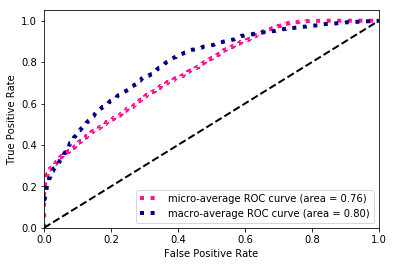

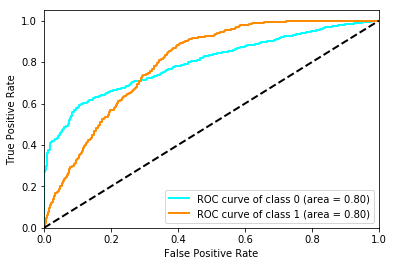

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.742192    0.522676     0.632434     0.665209      0.695845
precision     0.945398    0.373885     0.659641     0.665209      0.824732
recall        0.610887    0.868173     0.739530     0.665209      0.665209
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.796375    0.796375     0.796895     0.761885           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(17110, 314)
(17110, 2)
(2515, 314)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               161280    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)         

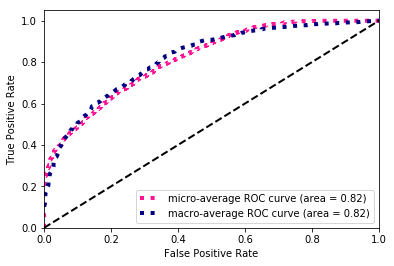

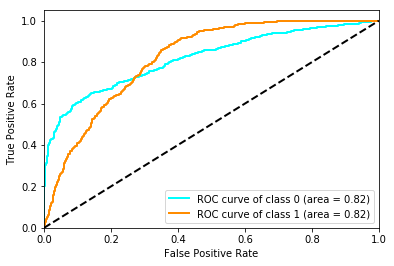

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.797486    0.536298     0.666892     0.718091      0.742341
precision     0.920237    0.410822     0.665529     0.718091      0.812683
recall        0.703629    0.772128     0.737879     0.718091      0.718091
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.818610    0.818610     0.819091     0.815850           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(17110, 314)
(17110, 2)
(2515, 314)
(2515, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               161280    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)         

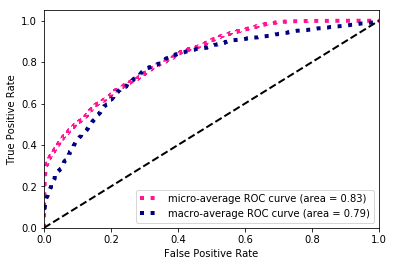

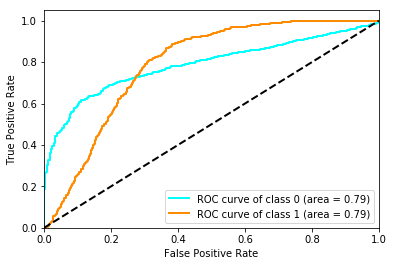

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.801020    0.532623     0.666822     0.720875      0.744353
precision     0.915155    0.411946     0.663551     0.720875      0.808911
recall        0.712198    0.753296     0.732747     0.720875      0.720875
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.787770    0.787770     0.788305     0.825650           NaN

******************** RNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(17110, 314)
(17110, 2)
(2515, 314)
(2515, 2)
(17110, 8, 25)
(17110, 14)
(17110, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

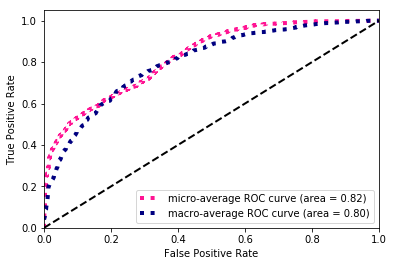

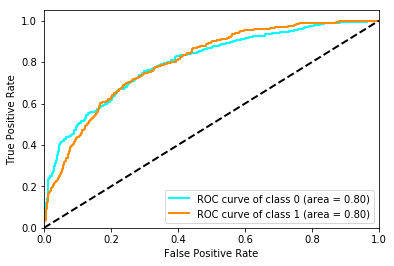

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.787983    0.517264     0.652623     0.705368      0.730825
precision     0.911317    0.395418     0.653368     0.705368      0.802394
recall        0.694052    0.747646     0.720849     0.705368      0.705368
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.799968    0.799968     0.800517     0.824610           NaN

******************** RNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(17110, 314)
(17110, 2)
(2515, 314)
(2515, 2)
(17110, 8, 25)
(17110, 14)
(17110, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

Epoch 42/60
 - 2s - loss: 0.3627 - f1_score: 0.7898 - val_loss: 1.2492 - val_f1_score: 0.2694
Epoch 43/60
 - 2s - loss: 0.3566 - f1_score: 0.7955 - val_loss: 1.5086 - val_f1_score: 0.2600
Epoch 44/60
 - 2s - loss: 0.3587 - f1_score: 0.7938 - val_loss: 0.7174 - val_f1_score: 0.4802
Epoch 45/60
 - 2s - loss: 0.3534 - f1_score: 0.7980 - val_loss: 1.8627 - val_f1_score: 0.2626
Epoch 46/60
 - 2s - loss: 0.3480 - f1_score: 0.8007 - val_loss: 1.0632 - val_f1_score: 0.3462
Epoch 47/60
 - 2s - loss: 0.3499 - f1_score: 0.7991 - val_loss: 0.9447 - val_f1_score: 0.5618
Epoch 48/60
 - 2s - loss: 0.3433 - f1_score: 0.8016 - val_loss: 3.1644 - val_f1_score: 0.0000e+00


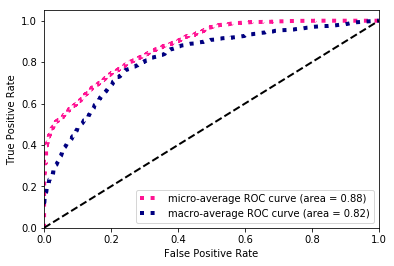

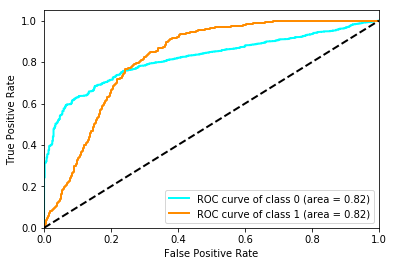

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.848693    0.539019     0.693856     0.772167      0.783310
precision     0.891292    0.470506     0.680899     0.772167      0.802450
recall        0.809980    0.630885     0.720432     0.772167      0.772167
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.819006    0.819007     0.819497     0.876460           NaN

******************** RNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(17110, 314)
(17110, 2)
(2515, 314)
(2515, 2)
(17110, 8, 25)
(17110, 14)
(17110, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

Epoch 42/60
 - 2s - loss: 0.3650 - f1_score: 0.7899 - val_loss: 1.0532 - val_f1_score: 0.3418
Epoch 43/60
 - 2s - loss: 0.3614 - f1_score: 0.7872 - val_loss: 2.9162 - val_f1_score: 0.0121
Epoch 44/60
 - 2s - loss: 0.3546 - f1_score: 0.7973 - val_loss: 1.1380 - val_f1_score: 0.4114
Epoch 45/60
 - 2s - loss: 0.3500 - f1_score: 0.7967 - val_loss: 0.7571 - val_f1_score: 0.3843
Epoch 46/60
 - 2s - loss: 0.3546 - f1_score: 0.7926 - val_loss: 0.8078 - val_f1_score: 0.3049
Epoch 47/60
 - 2s - loss: 0.3445 - f1_score: 0.7994 - val_loss: 1.6304 - val_f1_score: 0.0863
Epoch 48/60
 - 2s - loss: 0.3424 - f1_score: 0.8015 - val_loss: 1.6168 - val_f1_score: 0.0298
Epoch 49/60
 - 2s - loss: 0.3414 - f1_score: 0.8044 - val_loss: 1.2059 - val_f1_score: 0.2777
Epoch 50/60
 - 2s - loss: 0.3391 - f1_score: 0.8034 - val_loss: 1.2139 - val_f1_score: 0.2923
Epoch 51/60
 - 2s - loss: 0.3360 - f1_score: 0.8039 - val_loss: 2.4859 - val_f1_score: 0.0254
Epoch 52/60
 - 2s - loss: 0.3353 - f1_score: 0.8034 - val_lo

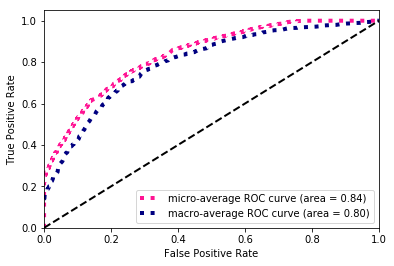

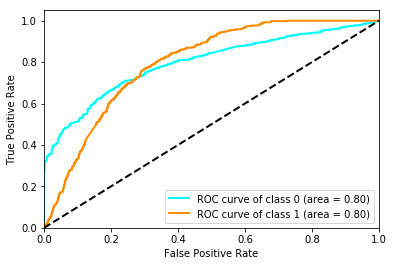

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.827362    0.527489     0.677425     0.747117      0.764048
precision     0.896471    0.435583     0.666027     0.747117      0.799162
recall        0.768145    0.668550     0.718348     0.747117      0.747117
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.796512    0.796512     0.797018     0.835923           NaN

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(17110, 315)
(17110, 2)
(2515, 315)
(2515, 2)
(17110, 8, 25)
(17110, 14)
(17110, 100)
(17110,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

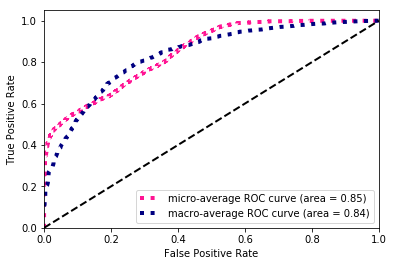

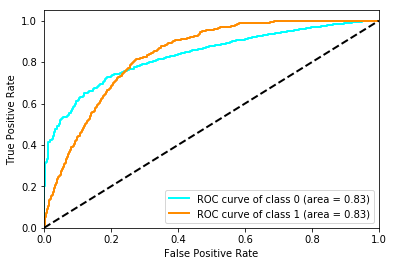

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.802305    0.560256     0.681281     0.727237      0.751201
precision     0.936743    0.424684     0.680714     0.727237      0.828630
recall        0.701613    0.822976     0.762294     0.727237      0.727237
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.834558    0.834558     0.835051     0.846867           NaN

******************** RNN_embed ********************
**********  round  1
load and test: shapes for train and test, X/Y
(17110, 315)
(17110, 2)
(2515, 315)
(2515, 2)
(17110, 8, 25)
(17110, 14)
(17110, 100)
(17110,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

Epoch 33/60
 - 2s - loss: 0.3962 - f1_score: 0.7694 - val_loss: 0.6776 - val_f1_score: 0.6122
Epoch 34/60
 - 2s - loss: 0.3903 - f1_score: 0.7720 - val_loss: 0.6652 - val_f1_score: 0.6181
Epoch 35/60
 - 2s - loss: 0.3914 - f1_score: 0.7727 - val_loss: 0.6090 - val_f1_score: 0.5369
Epoch 36/60
 - 2s - loss: 0.3843 - f1_score: 0.7716 - val_loss: 0.6647 - val_f1_score: 0.5053
Epoch 37/60
 - 2s - loss: 0.3887 - f1_score: 0.7702 - val_loss: 0.7373 - val_f1_score: 0.6118
Epoch 38/60
 - 2s - loss: 0.3863 - f1_score: 0.7777 - val_loss: 0.6985 - val_f1_score: 0.6279
Epoch 39/60
 - 2s - loss: 0.3815 - f1_score: 0.7782 - val_loss: 0.6714 - val_f1_score: 0.6095
Epoch 40/60
 - 2s - loss: 0.3751 - f1_score: 0.7789 - val_loss: 0.7877 - val_f1_score: 0.5995
Epoch 41/60
 - 2s - loss: 0.3763 - f1_score: 0.7794 - val_loss: 0.6654 - val_f1_score: 0.6299
Epoch 42/60
 - 2s - loss: 0.3760 - f1_score: 0.7827 - val_loss: 0.6737 - val_f1_score: 0.6133
Epoch 43/60
 - 2s - loss: 0.3649 - f1_score: 0.7879 - val_lo

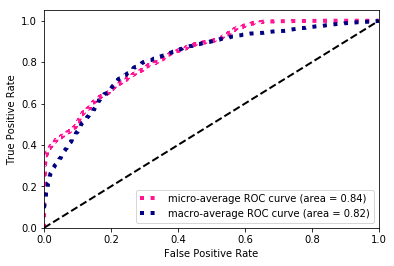

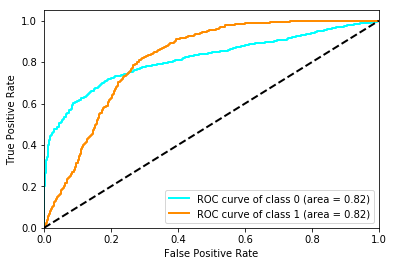

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.811487    0.561798     0.686642     0.736382      0.758769
precision     0.930855    0.432790     0.681822     0.736382      0.825697
recall        0.719254    0.800377     0.759815     0.736382      0.736382
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.815352    0.815352     0.815817     0.837672           NaN

******************** RNN_embed ********************
**********  round  2
load and test: shapes for train and test, X/Y
(17110, 315)
(17110, 2)
(2515, 315)
(2515, 2)
(17110, 8, 25)
(17110, 14)
(17110, 100)
(17110,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

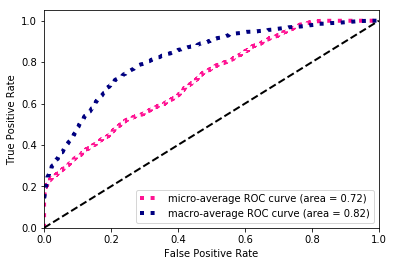

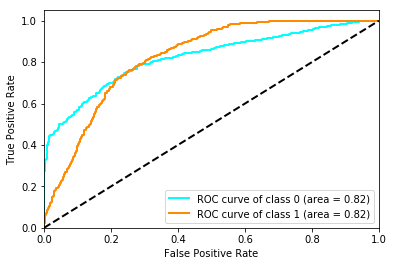

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.691613    0.504663     0.598138     0.619881      0.652142
precision     0.960573    0.348106     0.654340     0.619881      0.831261
recall        0.540323    0.917137     0.728730     0.619881      0.619881
support    1984.000000  531.000000  2515.000000  2515.000000   2515.000000
auc           0.823309    0.823309     0.823774     0.716438           NaN

In [12]:
Atlanta = compare_models(w=[1,1])

In [13]:
#Atlanta.to_csv('Atlanta.csv')
Atlanta

DNN       RNN  RNN_embed
0_f1-score              0.780233  0.821346   0.768468
1_f1-score              0.530532  0.527924   0.542239
weighted avg_f1-score   0.727513  0.759395   0.720704
0_precision             0.926930  0.899693   0.942724
1_precision             0.398884  0.433836   0.401860
weighted avg_precision  0.815442  0.801335   0.828529
0_recall                0.675571  0.757392   0.653730
1_recall                0.797866  0.682360   0.846830
weighted avg_recall     0.701392  0.741551   0.694500
0_auc                   0.800918  0.805162   0.824406
1_auc                   0.800918  0.805163   0.824406

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(30862, 314)
(30862, 2)
(6132, 314)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 512)               161280    
_________________________________________________________________
dense_77 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
activation_25 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)         

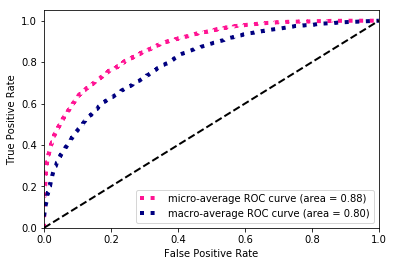

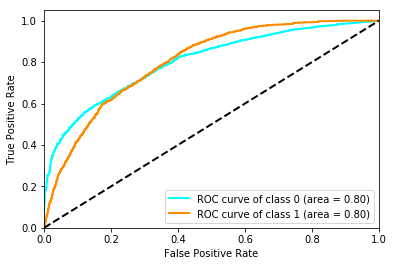

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.856719     0.520383     0.779354     0.688551      0.783386
precision     0.870267     0.494609     0.779354     0.682438      0.788360
recall        0.843587     0.548990     0.779354     0.696289      0.779354
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.801993     0.801993     0.876142     0.802191           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(30862, 314)
(30862, 2)
(6132, 314)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 512)               161280    
_________________________________________________________________
dense_81 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_27 (Batc (None, 256)               1024      
_________________________________________________________________
activation_27 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)         

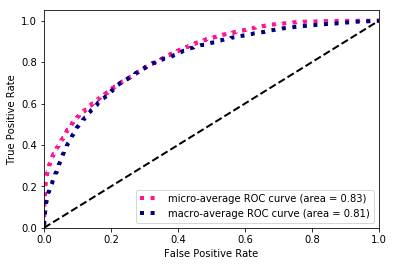

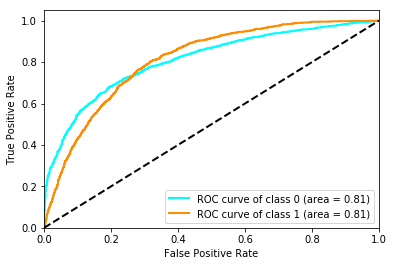

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.812622     0.545658     0.734671     0.679140      0.754414
precision     0.907407     0.435383     0.734671     0.671395      0.804489
recall        0.735766     0.730740     0.734671     0.733253      0.734671
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.809738     0.809738     0.832782     0.809946           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(30862, 314)
(30862, 2)
(6132, 314)
(6132, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 512)               161280    
_________________________________________________________________
dense_85 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_29 (Batc (None, 256)               1024      
_________________________________________________________________
activation_29 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)         

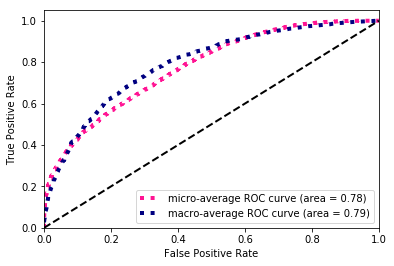

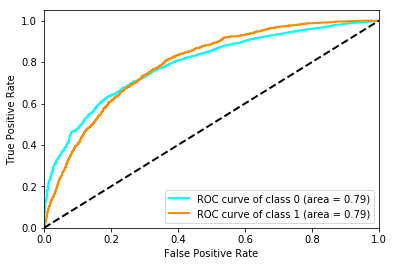

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.763132     0.517822     0.682322     0.640477      0.709646
precision     0.915136     0.386977     0.682322     0.651057      0.799978
recall        0.654432     0.782349     0.682322     0.718390      0.682322
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.791491     0.791491     0.775340     0.791690           NaN

******************** RNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(30862, 314)
(30862, 2)
(6132, 314)
(6132, 2)
(30862, 8, 25)
(30862, 14)
(30862, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_19 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

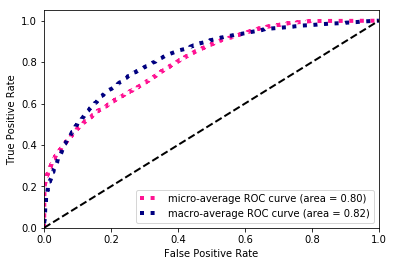

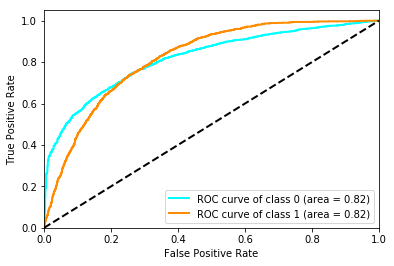

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.776054     0.539382     0.698630     0.657718      0.724451
precision     0.926237     0.404486     0.698630     0.665361      0.812476
recall        0.667779     0.809274     0.698630     0.738527      0.698630
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.819198     0.819198     0.803619     0.819407           NaN

******************** RNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(30862, 314)
(30862, 2)
(6132, 314)
(6132, 2)
(30862, 8, 25)
(30862, 14)
(30862, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_21 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

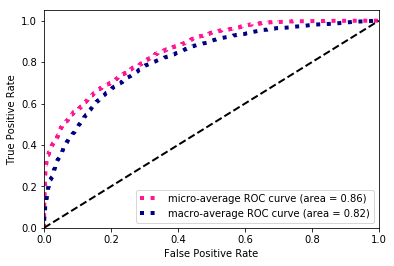

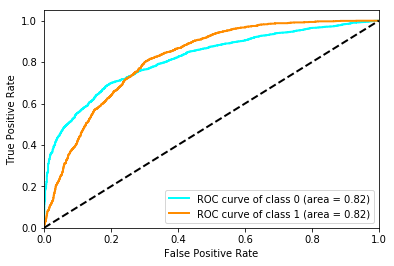

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.828934     0.546861     0.751631     0.687898      0.767432
precision     0.898247     0.454051     0.751631     0.676149      0.801396
recall        0.769552     0.687360     0.751631     0.728456      0.751631
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.816503     0.816503     0.855633     0.816704           NaN

******************** RNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(30862, 314)
(30862, 2)
(6132, 314)
(6132, 2)
(30862, 8, 25)
(30862, 14)
(30862, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_23 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

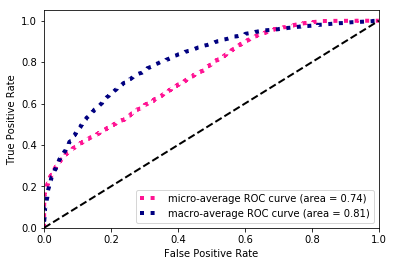

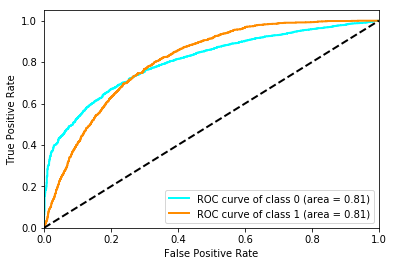

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.718214     0.516715     0.643999     0.617464      0.674279
precision     0.942412     0.366981     0.643999     0.654697      0.816947
recall        0.580188     0.872850     0.643999     0.726519      0.643999
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.806530     0.806530     0.743104     0.806731           NaN

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(30862, 315)
(30862, 2)
(6132, 315)
(6132, 2)
(30862, 8, 25)
(30862, 14)
(30862, 100)
(30862,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

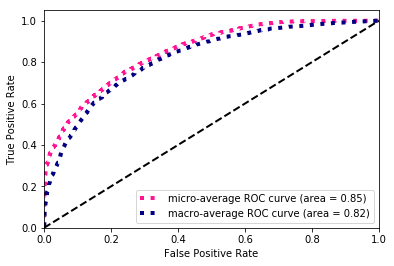

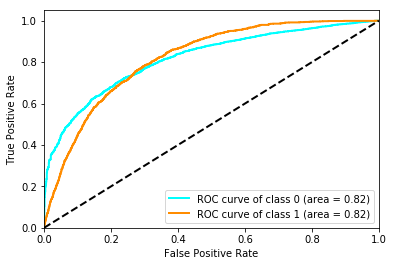

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.831837     0.553635     0.755708     0.692736      0.771179
precision     0.900802     0.460129     0.755708     0.680466      0.804719
recall        0.772680     0.694839     0.755708     0.733760      0.755708
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.817891     0.817891     0.849950     0.818087           NaN

******************** RNN_embed ********************
**********  round  1
load and test: shapes for train and test, X/Y
(30862, 315)
(30862, 2)
(6132, 315)
(6132, 2)
(30862, 8, 25)
(30862, 14)
(30862, 100)
(30862,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

Epoch 33/60
 - 2s - loss: 0.4052 - f1_score: 0.4656 - val_loss: 0.3515 - val_f1_score: 0.2402
Epoch 34/60
 - 2s - loss: 0.4052 - f1_score: 0.4553 - val_loss: 0.3512 - val_f1_score: 0.4093
Epoch 35/60
 - 2s - loss: 0.4048 - f1_score: 0.4660 - val_loss: 0.3721 - val_f1_score: 0.4459
Epoch 36/60
 - 2s - loss: 0.4058 - f1_score: 0.4510 - val_loss: 0.3503 - val_f1_score: 0.0588
Epoch 37/60
 - 2s - loss: 0.4062 - f1_score: 0.4553 - val_loss: 0.3309 - val_f1_score: 0.1773
Epoch 38/60
 - 2s - loss: 0.4042 - f1_score: 0.4732 - val_loss: 0.3396 - val_f1_score: 0.2220
Epoch 39/60
 - 2s - loss: 0.4050 - f1_score: 0.4646 - val_loss: 0.3449 - val_f1_score: 0.2287
Epoch 40/60
 - 2s - loss: 0.4023 - f1_score: 0.4615 - val_loss: 0.3417 - val_f1_score: 0.1517
Epoch 41/60
 - 2s - loss: 0.4044 - f1_score: 0.4628 - val_loss: 0.3817 - val_f1_score: 0.3556
Epoch 42/60
 - 2s - loss: 0.4027 - f1_score: 0.4662 - val_loss: 0.3356 - val_f1_score: 0.0000e+00
Epoch 43/60
 - 2s - loss: 0.4029 - f1_score: 0.4658 - va

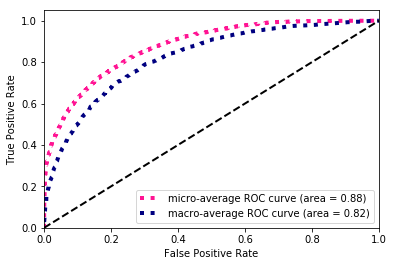

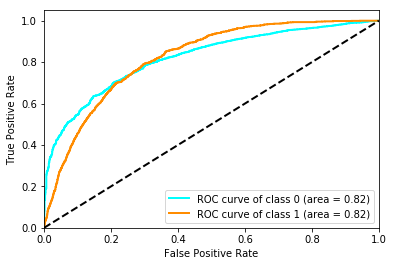

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.855294     0.551171     0.781148     0.703232      0.788984
precision     0.885466     0.498488     0.781148     0.691977      0.801090
recall        0.827112     0.616305     0.781148     0.721708      0.781148
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.820831     0.820831     0.875796     0.821029           NaN

******************** RNN_embed ********************
**********  round  2
load and test: shapes for train and test, X/Y
(30862, 315)
(30862, 2)
(6132, 315)
(6132, 2)
(30862, 8, 25)
(30862, 14)
(30862, 100)
(30862,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

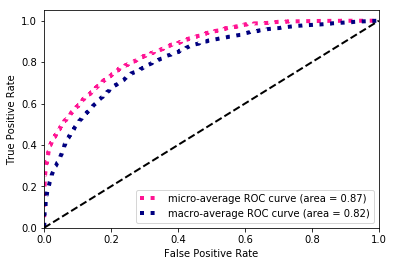

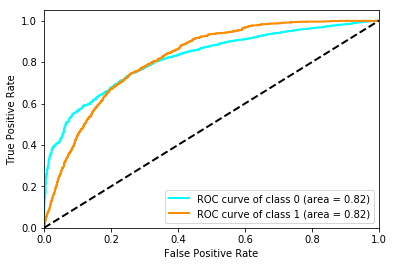

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.846704     0.561536     0.772831     0.704120      0.784527
precision     0.896319     0.484783     0.772831     0.690551      0.806589
recall        0.802294     0.667165     0.772831     0.734730      0.772831
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.818771     0.818771     0.865362     0.818976           NaN

******************** ATT ********************
**********  round  0
load and test: shapes for train and test, X/Y
(30862, 315)
(30862, 2)
(6132, 315)
(6132, 2)
(30862, 8, 25)
(30862, 14)
(30862, 100)
(30862,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_31 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
lstm_32 (LSTM)                  (None, 8, 128)       131584      lstm_31[0][0]                    
__________________________________________________________________________________________________


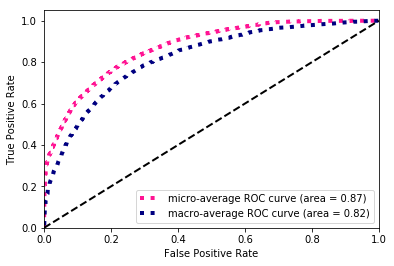

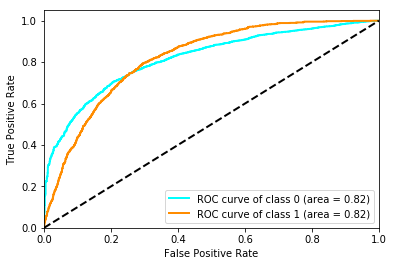

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.853688     0.548785     0.779028     0.701236      0.787208
precision     0.885132     0.494598     0.779028     0.689865      0.799981
recall        0.824400     0.616305     0.779028     0.720353      0.779028
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.818145     0.818145     0.869643     0.818350           NaN

******************** ATT ********************
**********  round  1
load and test: shapes for train and test, X/Y
(30862, 315)
(30862, 2)
(6132, 315)
(6132, 2)
(30862, 8, 25)
(30862, 14)
(30862, 100)
(30862,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_33 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
lstm_34 (LSTM)                  (None, 8, 128)       131584      lstm_33[0][0]                    
__________________________________________________________________________________________________


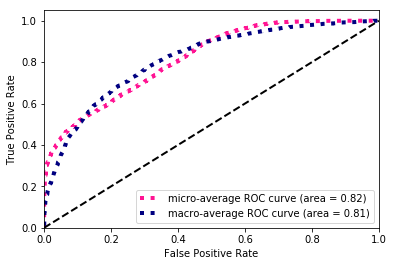

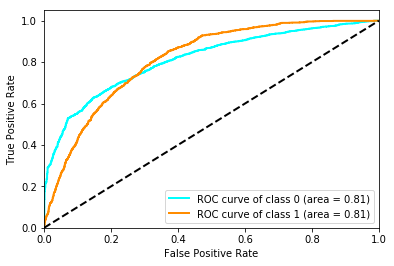

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.780082     0.540554     0.702544     0.660318      0.727856
precision     0.924550     0.407520     0.702544     0.666035      0.811818
recall        0.674661     0.802543     0.702544     0.738602      0.702544
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.813188     0.813188     0.816061     0.813387           NaN

******************** ATT ********************
**********  round  2
load and test: shapes for train and test, X/Y
(30862, 315)
(30862, 2)
(6132, 315)
(6132, 2)
(30862, 8, 25)
(30862, 14)
(30862, 100)
(30862,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_35 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
lstm_36 (LSTM)                  (None, 8, 128)       131584      lstm_35[0][0]                    
__________________________________________________________________________________________________


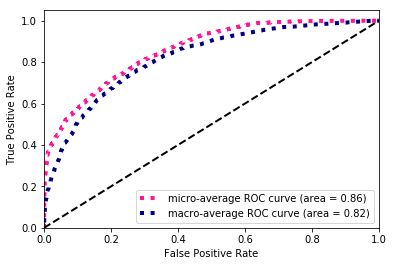

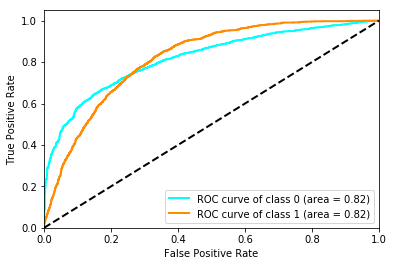

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.832025     0.552301     0.755708     0.692163      0.771035
precision     0.899830     0.459930     0.755708     0.679880      0.803916
recall        0.773723     0.691099     0.755708     0.732411      0.755708
support    4795.000000  1337.000000  6132.000000  6132.000000   6132.000000
auc           0.819614     0.819614     0.857508     0.819811           NaN

In [14]:
LosAngeles =compare_models('LosAngeles',w=[1,1])

In [15]:
LosAngeles.to_csv('LosAngeles.csv')
LosAngeles

DNN       RNN  RNN_embed       ATT
0_f1-score              0.810825  0.774401   0.844612  0.821932
1_f1-score              0.527954  0.534319   0.555447  0.547213
weighted avg_f1-score   0.749149  0.722054   0.781563  0.762033
0_precision             0.897603  0.922299   0.894196  0.903171
1_precision             0.438990  0.408506   0.481133  0.454016
weighted avg_precision  0.797609  0.810273   0.804133  0.805239
0_recall                0.744595  0.672506   0.800695  0.757595
1_recall                0.687360  0.789828   0.659437  0.703316
weighted avg_recall     0.732116  0.698087   0.769896  0.745760
0_auc                   0.801074  0.814077   0.819164  0.816982
1_auc                   0.801074  0.814077   0.819164  0.816982

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(22890, 314)
(22890, 2)
(4664, 314)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_151 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_152 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_49 (Batc (None, 256)               1024      
_________________________________________________________________
activation_49 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)         

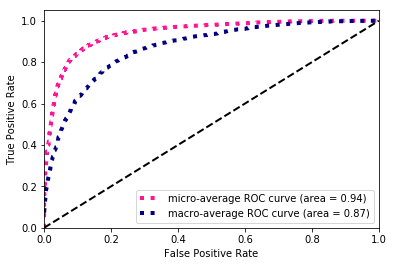

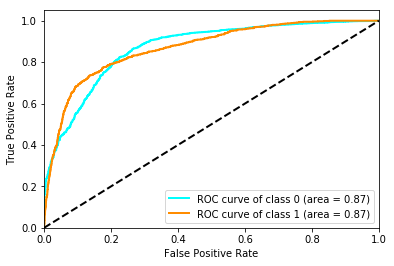

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.925510    0.607527     0.874786     0.766519      0.870899
precision     0.912245    0.657933     0.874786     0.785089      0.868570
recall        0.939166    0.564295     0.874786     0.751731      0.874786
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.868869    0.868869     0.940584     0.869187           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(22890, 314)
(22890, 2)
(4664, 314)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_155 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_156 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_51 (Batc (None, 256)               1024      
_________________________________________________________________
activation_51 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)         

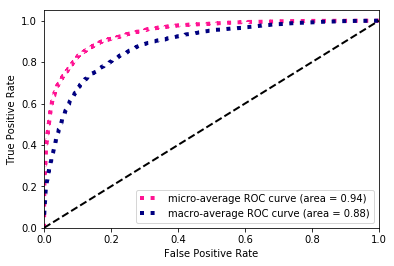

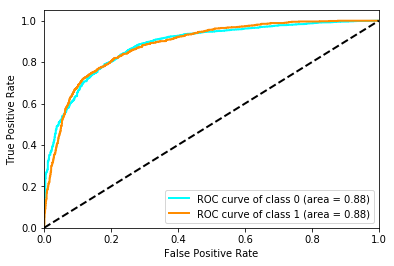

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.919131    0.633452     0.867496     0.776292      0.870068
precision     0.929346    0.603390     0.867496     0.766368      0.873366
recall        0.909138    0.666667     0.867496     0.787902      0.867496
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.882816    0.882816     0.941212     0.883089           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(22890, 314)
(22890, 2)
(4664, 314)
(4664, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_159 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_160 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_53 (Batc (None, 256)               1024      
_________________________________________________________________
activation_53 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)         

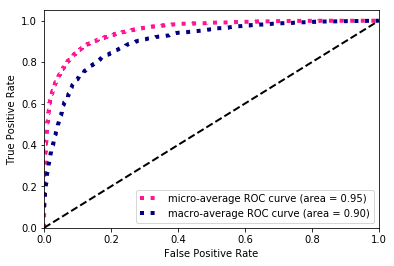

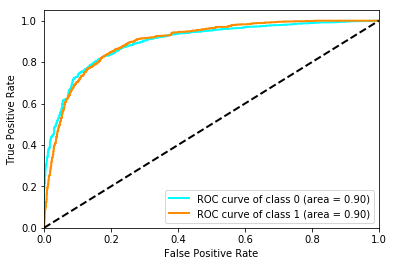

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.927443    0.633355     0.878859     0.780399      0.876936
precision     0.920234    0.659459     0.878859     0.789847      0.875449
recall        0.934766    0.609238     0.878859     0.772002      0.878859
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.899123    0.899123     0.950532     0.899388           NaN

******************** RNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(22890, 314)
(22890, 2)
(4664, 314)
(4664, 2)
(22890, 8, 25)
(22890, 14)
(22890, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_37 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

Epoch 43/60
 - 2s - loss: 0.2798 - f1_score: 0.5935 - val_loss: 0.1892 - val_f1_score: 0.1730
Epoch 44/60
 - 2s - loss: 0.2788 - f1_score: 0.5984 - val_loss: 0.2119 - val_f1_score: 0.4383
Epoch 45/60
 - 2s - loss: 0.2787 - f1_score: 0.5943 - val_loss: 0.2219 - val_f1_score: 0.4101
Epoch 46/60
 - 2s - loss: 0.2808 - f1_score: 0.5930 - val_loss: 0.2709 - val_f1_score: 0.3907
Epoch 47/60
 - 2s - loss: 0.2796 - f1_score: 0.5949 - val_loss: 0.1995 - val_f1_score: 0.0706
Epoch 48/60
 - 2s - loss: 0.2788 - f1_score: 0.5936 - val_loss: 0.3034 - val_f1_score: 0.3903
Epoch 49/60
 - 2s - loss: 0.2772 - f1_score: 0.5979 - val_loss: 0.3140 - val_f1_score: 0.3268
Epoch 50/60
 - 2s - loss: 0.2780 - f1_score: 0.5983 - val_loss: 0.2003 - val_f1_score: 0.2000


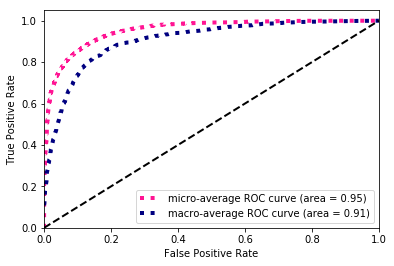

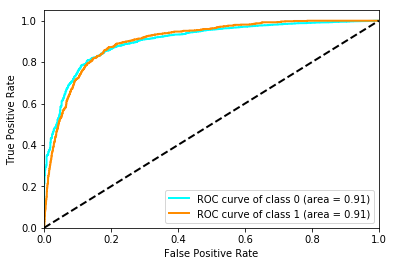

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.927628    0.607438     0.877787     0.767533      0.872638
precision     0.910292    0.677419     0.877787     0.793855      0.870298
recall        0.945638    0.550562     0.877787     0.748100      0.877787
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.905025    0.905025     0.953112     0.905274           NaN

******************** RNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(22890, 314)
(22890, 2)
(4664, 314)
(4664, 2)
(22890, 8, 25)
(22890, 14)
(22890, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_39 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

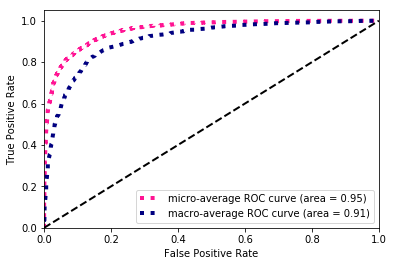

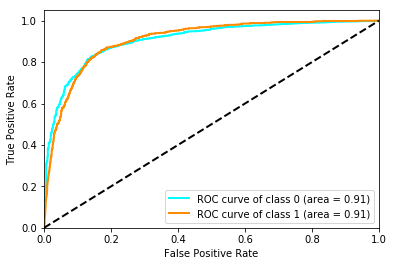

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.926223    0.644195     0.877787     0.785209      0.877787
precision     0.926223    0.644195     0.877787     0.785209      0.877787
recall        0.926223    0.644195     0.877787     0.785209      0.877787
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.908359    0.908359     0.954118     0.908605           NaN

******************** RNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(22890, 314)
(22890, 2)
(4664, 314)
(4664, 2)
(22890, 8, 25)
(22890, 14)
(22890, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_41 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

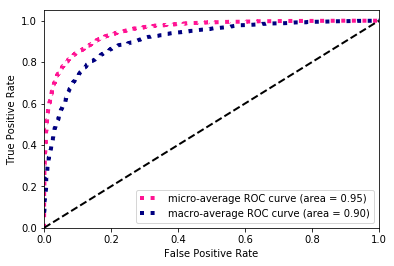

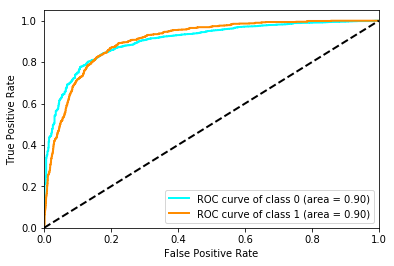

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.924538    0.617188     0.873928     0.770863      0.871753
precision     0.916773    0.644898     0.873928     0.780835      0.870081
recall        0.932436    0.591760     0.873928     0.762098      0.873928
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.904671    0.904671     0.952169     0.904922           NaN

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(22890, 315)
(22890, 2)
(4664, 315)
(4664, 2)
(22890, 8, 25)
(22890, 14)
(22890, 100)
(22890,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

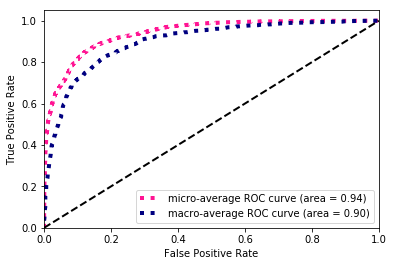

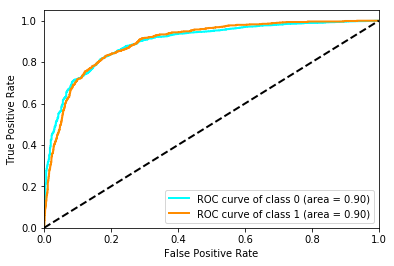

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.914286    0.642263     0.861707     0.778274      0.867568
precision     0.939377    0.577844     0.861707     0.758611      0.877287
recall        0.890500    0.722846     0.861707     0.806673      0.861707
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.896997    0.896997     0.938774     0.897261           NaN

******************** RNN_embed ********************
**********  round  1
load and test: shapes for train and test, X/Y
(22890, 315)
(22890, 2)
(4664, 315)
(4664, 2)
(22890, 8, 25)
(22890, 14)
(22890, 100)
(22890,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

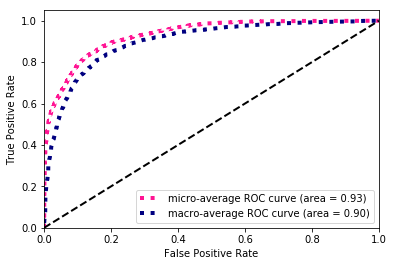

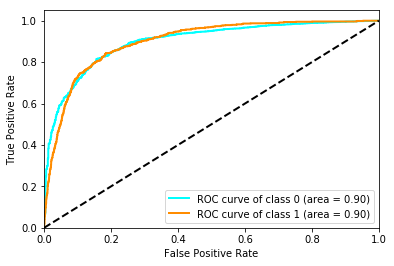

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.904484    0.637904     0.848842     0.771194      0.858702
precision     0.948835    0.541885     0.848842     0.745360      0.878945
recall        0.864095    0.775281     0.848842     0.819688      0.848842
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.898808    0.898808     0.931150     0.899090           NaN

******************** RNN_embed ********************
**********  round  2
load and test: shapes for train and test, X/Y
(22890, 315)
(22890, 2)
(4664, 315)
(4664, 2)
(22890, 8, 25)
(22890, 14)
(22890, 100)
(22890,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

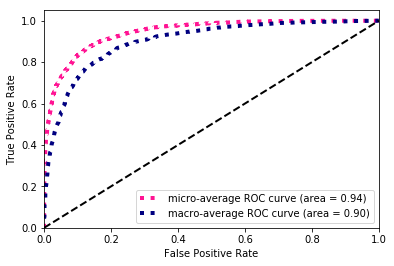

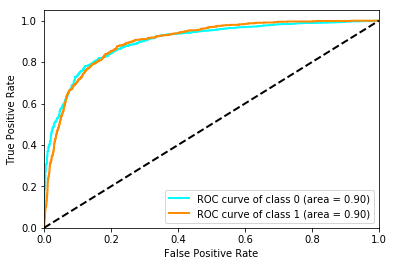

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.919104    0.646720     0.868353     0.782912      0.872325
precision     0.935873    0.599787     0.868353     0.767830      0.878153
recall        0.902925    0.701623     0.868353     0.802274      0.868353
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.900665    0.900665     0.944433     0.900928           NaN

******************** ATT ********************
**********  round  0
load and test: shapes for train and test, X/Y
(22890, 315)
(22890, 2)
(4664, 315)
(4664, 2)
(22890, 8, 25)
(22890, 14)
(22890, 100)
(22890,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_49 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
lstm_50 (LSTM)                  (None, 8, 128)       131584      lstm_49[0][0]                    
__________________________________________________________________________________________________


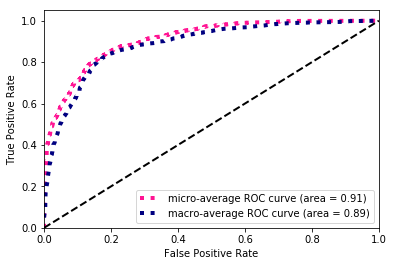

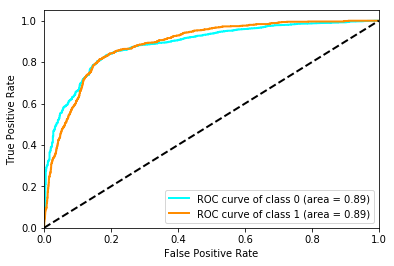

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.889719    0.620657     0.829117     0.755188      0.843510
precision     0.955707    0.501538     0.829117     0.728623      0.877708
recall        0.832255    0.813983     0.829117     0.823119      0.829117
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.885022    0.885022     0.909658     0.885301           NaN

******************** ATT ********************
**********  round  1
load and test: shapes for train and test, X/Y
(22890, 315)
(22890, 2)
(4664, 315)
(4664, 2)
(22890, 8, 25)
(22890, 14)
(22890, 100)
(22890,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_51 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
lstm_52 (LSTM)                  (None, 8, 128)       131584      lstm_51[0][0]                    
__________________________________________________________________________________________________


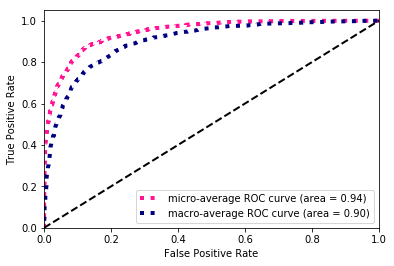

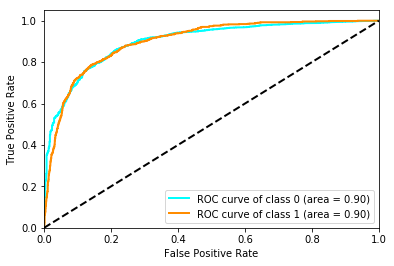

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.922328    0.659353     0.873499     0.790840      0.877164
precision     0.938387    0.613319     0.873499     0.775853      0.882560
recall        0.906808    0.712859     0.873499     0.809834      0.873499
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.899532    0.899532     0.943448     0.899792           NaN

******************** ATT ********************
**********  round  2
load and test: shapes for train and test, X/Y
(22890, 315)
(22890, 2)
(4664, 315)
(4664, 2)
(22890, 8, 25)
(22890, 14)
(22890, 100)
(22890,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_53 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
lstm_54 (LSTM)                  (None, 8, 128)       131584      lstm_53[0][0]                    
__________________________________________________________________________________________________


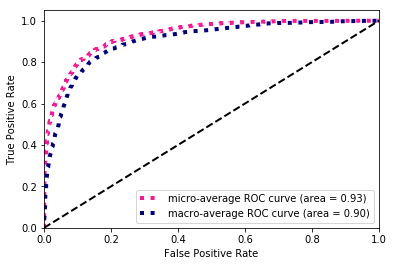

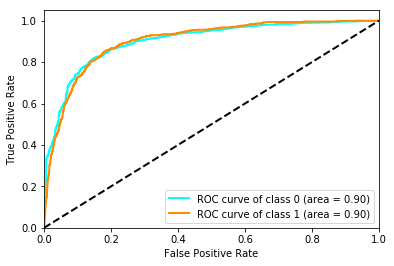

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.907515    0.648482     0.853559     0.777998      0.863029
precision     0.951448    0.551664     0.853559     0.751556      0.882789
recall        0.867461    0.786517     0.853559     0.826989      0.853559
support    3863.000000  801.000000  4664.000000  4664.000000   4664.000000
auc           0.901643    0.901643     0.930473     0.901903           NaN

In [16]:
Austin =compare_models('Austin',w=[1,1])

In [17]:
Austin.to_csv('Austin.csv')
Austin

DNN       RNN  RNN_embed       ATT
0_f1-score              0.924028  0.926130   0.912625  0.906521
1_f1-score              0.624778  0.622940   0.642296  0.642831
weighted avg_f1-score   0.872635  0.874060   0.866198  0.861234
0_precision             0.920609  0.917762   0.941362  0.948514
1_precision             0.640261  0.655504   0.573172  0.555507
weighted avg_precision  0.872462  0.872722   0.878128  0.881019
0_recall                0.927690  0.934766   0.885840  0.868841
1_recall                0.613400  0.595506   0.733250  0.771119
weighted avg_recall     0.873714  0.876501   0.859634  0.852058
0_auc                   0.883603  0.906018   0.898823  0.895399
1_auc                   0.883603  0.906018   0.898823  0.895399

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(7671, 314)
(7671, 2)
(1561, 314)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_226 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_227 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_73 (Batc (None, 256)               1024      
_________________________________________________________________
activation_73 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 256)           

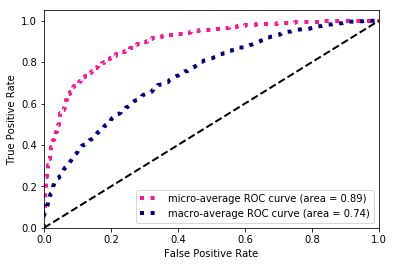

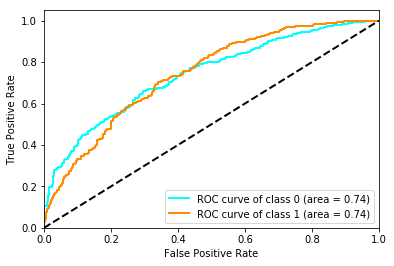

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.889472    0.348786     0.811019     0.619129      0.800454
precision     0.869597    0.403061     0.811019     0.636329      0.792788
recall        0.910276    0.307393     0.811019     0.608835      0.811019
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.741203    0.741203     0.893556     0.742173           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(7671, 314)
(7671, 2)
(1561, 314)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_230 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_231 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_75 (Batc (None, 256)               1024      
_________________________________________________________________
activation_75 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 256)           

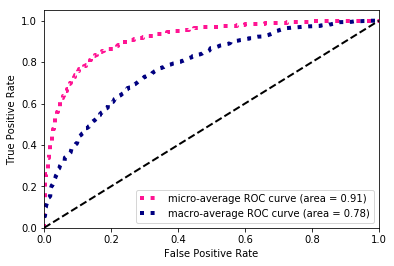

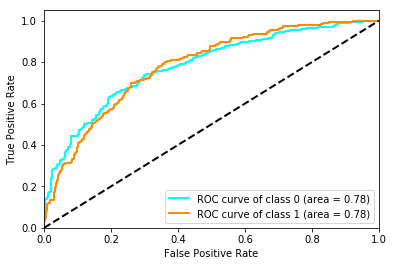

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.909091    0.349869     0.840487     0.629480      0.817022
precision     0.867596    0.531746     0.840487     0.699671      0.812302
recall        0.954755    0.260700     0.840487     0.607727      0.840487
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.781627    0.781627     0.912392     0.782599           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(7671, 314)
(7671, 2)
(1561, 314)
(1561, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_234 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_235 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_77 (Batc (None, 256)               1024      
_________________________________________________________________
activation_77 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 256)           

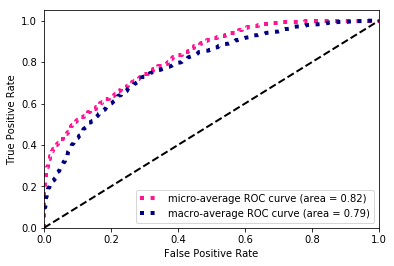

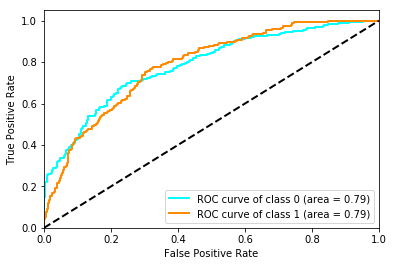

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.810648    0.443884     0.717489     0.627266      0.750265
precision     0.920976    0.328358     0.717489     0.624667      0.823408
recall        0.723926    0.684825     0.717489     0.704376      0.717489
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.785151    0.785151     0.823606     0.786192           NaN

******************** RNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(7671, 314)
(7671, 2)
(1561, 314)
(1561, 2)
(7671, 8, 25)
(7671, 14)
(7671, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_55 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input (Inp

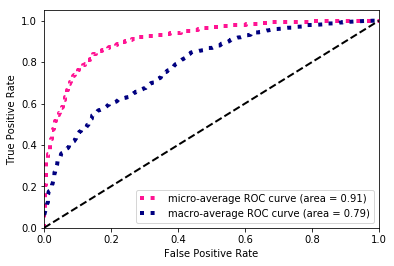

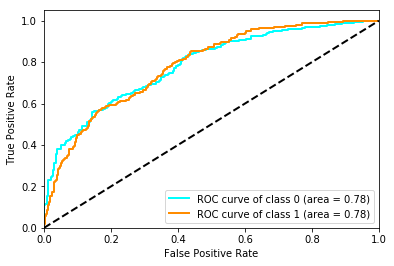

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.910891    0.384810     0.844331     0.647851      0.824278
precision     0.872804    0.550725     0.844331     0.711764      0.819777
recall        0.952454    0.295720     0.844331     0.624087      0.844331
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.784500    0.784500     0.912516     0.785423           NaN

******************** RNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(7671, 314)
(7671, 2)
(1561, 314)
(1561, 2)
(7671, 8, 25)
(7671, 14)
(7671, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_57 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input (Inp

/users/PAS0536/osu9965/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


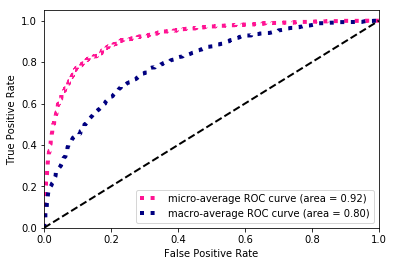

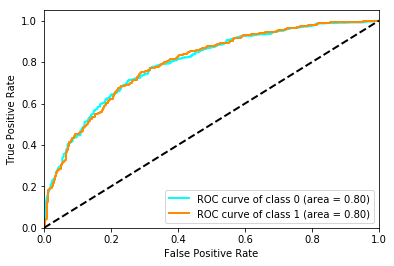

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.910297    0.000000     0.835362     0.455148      0.760427
precision     0.835362    0.000000     0.835362     0.417681      0.697830
recall        1.000000    0.000000     0.835362     0.500000      0.835362
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.795899    0.795965     0.916762     0.796799           NaN

******************** RNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(7671, 314)
(7671, 2)
(1561, 314)
(1561, 2)
(7671, 8, 25)
(7671, 14)
(7671, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_59 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input (Inp

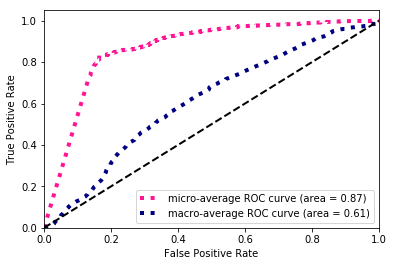

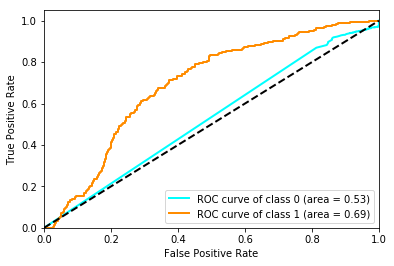

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.910297    0.000000     0.835362     0.455148      0.760427
precision     0.835362    0.000000     0.835362     0.417681      0.697830
recall        1.000000    0.000000     0.835362     0.500000      0.835362
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.527340    0.692186     0.865554     0.610892           NaN

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(7671, 315)
(7671, 2)
(1561, 315)
(1561, 2)
(7671, 8, 25)
(7671, 14)
(7671, 100)
(7671,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________


 - 1s - loss: 0.3156 - f1_score: 0.2843 - val_loss: 0.2575 - val_f1_score: 0.1600
Epoch 33/60
 - 1s - loss: 0.3194 - f1_score: 0.3394 - val_loss: 0.2340 - val_f1_score: 0.0000e+00
Epoch 34/60
 - 1s - loss: 0.3211 - f1_score: 0.2722 - val_loss: 0.2485 - val_f1_score: 0.1806
Epoch 35/60
 - 1s - loss: 0.3147 - f1_score: 0.3159 - val_loss: 0.2347 - val_f1_score: 0.0708
Epoch 36/60
 - 1s - loss: 0.3176 - f1_score: 0.2932 - val_loss: 0.2577 - val_f1_score: 0.1186
Epoch 37/60
 - 1s - loss: 0.3167 - f1_score: 0.2955 - val_loss: 0.2720 - val_f1_score: 0.0000e+00
Epoch 38/60
 - 1s - loss: 0.3143 - f1_score: 0.3385 - val_loss: 0.2596 - val_f1_score: 0.1760
Epoch 39/60
 - 1s - loss: 0.3145 - f1_score: 0.3027 - val_loss: 0.2707 - val_f1_score: 0.2105


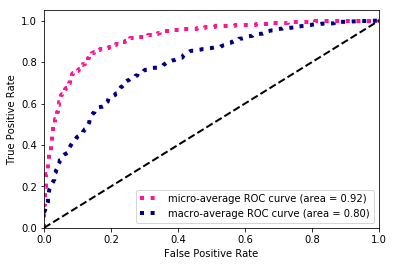

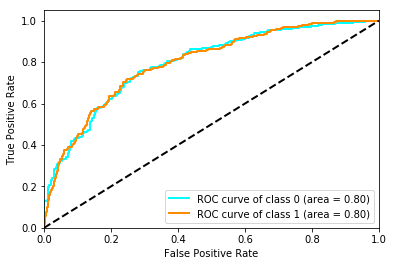

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.913155    0.396947     0.848174     0.655051      0.828167
precision     0.874386    0.573529     0.848174     0.723958      0.824854
recall        0.955521    0.303502     0.848174     0.629512      0.848174
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.795544    0.795544     0.915509     0.796513           NaN

******************** RNN_embed ********************
**********  round  1
load and test: shapes for train and test, X/Y
(7671, 315)
(7671, 2)
(1561, 315)
(1561, 2)
(7671, 8, 25)
(7671, 14)
(7671, 100)
(7671,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________


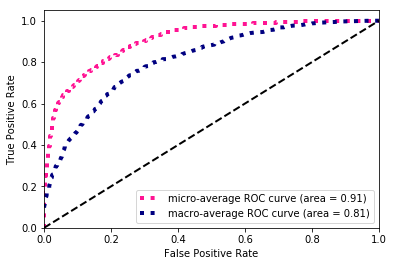

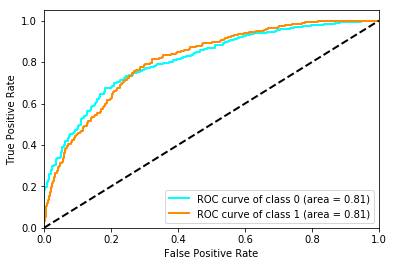

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.883268    0.456522     0.807816     0.669895      0.813010
precision     0.896524    0.427119     0.807816     0.661822      0.819242
recall        0.870399    0.490272     0.807816     0.680336      0.807816
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.809968    0.809968     0.906234     0.810868           NaN

******************** RNN_embed ********************
**********  round  2
load and test: shapes for train and test, X/Y
(7671, 315)
(7671, 2)
(1561, 315)
(1561, 2)
(7671, 8, 25)
(7671, 14)
(7671, 100)
(7671,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________


Epoch 33/60
 - 1s - loss: 0.3149 - f1_score: 0.3178 - val_loss: 0.3698 - val_f1_score: 0.2908
Epoch 34/60
 - 1s - loss: 0.3153 - f1_score: 0.3636 - val_loss: 0.2795 - val_f1_score: 0.2125
Epoch 35/60
 - 1s - loss: 0.3148 - f1_score: 0.2825 - val_loss: 0.2976 - val_f1_score: 0.2486
Epoch 36/60
 - 1s - loss: 0.3195 - f1_score: 0.3344 - val_loss: 0.2902 - val_f1_score: 0.1752
Epoch 37/60
 - 1s - loss: 0.3168 - f1_score: 0.2960 - val_loss: 0.2461 - val_f1_score: 0.1583
Epoch 38/60
 - 1s - loss: 0.3170 - f1_score: 0.3331 - val_loss: 0.2335 - val_f1_score: 0.1429
Epoch 39/60
 - 1s - loss: 0.3134 - f1_score: 0.3316 - val_loss: 0.2256 - val_f1_score: 0.1504
Epoch 40/60
 - 1s - loss: 0.3160 - f1_score: 0.3214 - val_loss: 0.2913 - val_f1_score: 0.2626
Epoch 41/60
 - 1s - loss: 0.3130 - f1_score: 0.3211 - val_loss: 0.2556 - val_f1_score: 0.2192
Epoch 42/60
 - 1s - loss: 0.3133 - f1_score: 0.3318 - val_loss: 0.2512 - val_f1_score: 0.1818


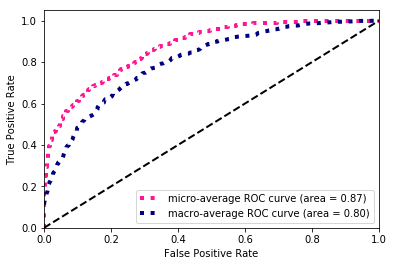

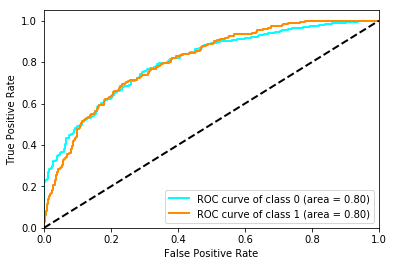

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.849462    0.482955     0.766816     0.666208      0.789121
precision     0.921903    0.380313     0.766816     0.651108      0.832737
recall        0.787577    0.661479     0.766816     0.724528      0.766816
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.803860    0.803860     0.870813     0.804819           NaN

******************** ATT ********************
**********  round  0
load and test: shapes for train and test, X/Y
(7671, 315)
(7671, 2)
(1561, 315)
(1561, 2)
(7671, 8, 25)
(7671, 14)
(7671, 100)
(7671,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_67 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
lstm_68 (LSTM)                  (None, 8, 128)       131584      lstm_67[0][0]                    
__________________________________________________________________________________________________
geo_co

 - 1s - loss: 0.3177 - f1_score: 0.2935 - val_loss: 0.2780 - val_f1_score: 0.2043
Epoch 27/60
 - 1s - loss: 0.3213 - f1_score: 0.2263 - val_loss: 0.6555 - val_f1_score: 0.2091
Epoch 28/60
 - 1s - loss: 0.3235 - f1_score: 0.2795 - val_loss: 0.4812 - val_f1_score: 0.2645
Epoch 29/60
 - 1s - loss: 0.3218 - f1_score: 0.2784 - val_loss: 0.2224 - val_f1_score: 0.1840
Epoch 30/60
 - 1s - loss: 0.3179 - f1_score: 0.3189 - val_loss: 0.6218 - val_f1_score: 0.2055
Epoch 31/60
 - 1s - loss: 0.3179 - f1_score: 0.3077 - val_loss: 0.2362 - val_f1_score: 0.2062
Epoch 32/60
 - 1s - loss: 0.3163 - f1_score: 0.3308 - val_loss: 0.7146 - val_f1_score: 0.1588
Epoch 33/60
 - 1s - loss: 0.3171 - f1_score: 0.3037 - val_loss: 0.2223 - val_f1_score: 0.1806
Epoch 34/60
 - 1s - loss: 0.3147 - f1_score: 0.2883 - val_loss: 0.3654 - val_f1_score: 0.3243


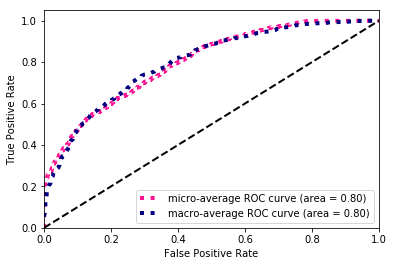

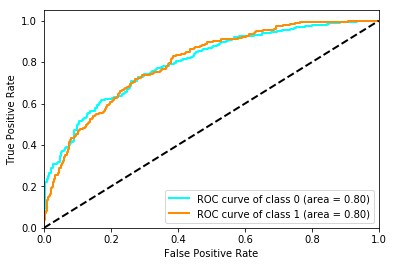

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.794195    0.448113     0.700192     0.621154      0.737217
precision     0.930928    0.321489     0.700192     0.626208      0.830591
recall        0.692485    0.739300     0.700192     0.715892      0.700192
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.797922    0.797922     0.799110     0.798926           NaN

******************** ATT ********************
**********  round  1
load and test: shapes for train and test, X/Y
(7671, 315)
(7671, 2)
(1561, 315)
(1561, 2)
(7671, 8, 25)
(7671, 14)
(7671, 100)
(7671,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_69 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
lstm_70 (LSTM)                  (None, 8, 128)       131584      lstm_69[0][0]                    
__________________________________________________________________________________________________
geo_co

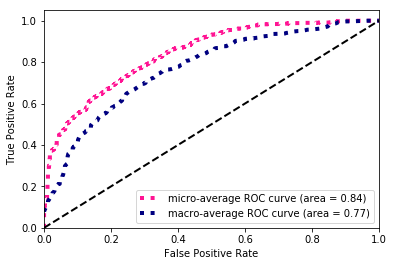

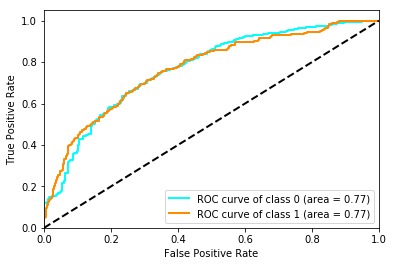

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.831180    0.439834     0.740551     0.635507      0.766749
precision     0.910502    0.341202     0.740551     0.625852      0.816774
recall        0.764571    0.618677     0.740551     0.691624      0.740551
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.768339    0.768339     0.840954     0.769322           NaN

******************** ATT ********************
**********  round  2
load and test: shapes for train and test, X/Y
(7671, 315)
(7671, 2)
(1561, 315)
(1561, 2)
(7671, 8, 25)
(7671, 14)
(7671, 100)
(7671,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_71 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
lstm_72 (LSTM)                  (None, 8, 128)       131584      lstm_71[0][0]                    
__________________________________________________________________________________________________
geo_co

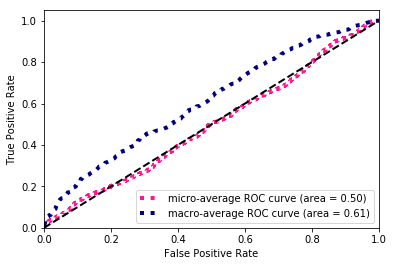

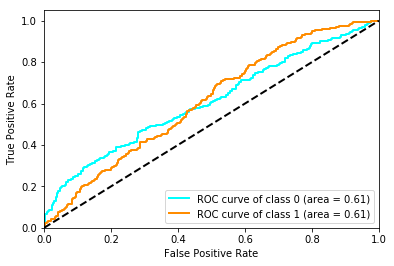

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.607287    0.322862     0.502883     0.465075      0.560460
precision     0.892857    0.208099     0.502883     0.550478      0.780120
recall        0.460123    0.719844     0.502883     0.589984      0.502883
support    1304.000000  257.000000  1561.000000  1561.000000   1561.000000
auc           0.609191    0.609191     0.498128     0.610341           NaN

In [18]:
Miami =compare_models('Miami',w=[1,1])

In [19]:
Miami.to_csv('Miami.csv')
Miami

DNN       RNN  RNN_embed       ATT
0_f1-score              0.869737  0.910495   0.881962  0.744221
1_f1-score              0.380846  0.128270   0.445474  0.403603
weighted avg_f1-score   0.789247  0.781711   0.810099  0.688142
0_precision             0.886056  0.847843   0.897605  0.911429
1_precision             0.421055  0.183575   0.460320  0.290263
weighted avg_precision  0.809499  0.738479   0.825611  0.809162
0_recall                0.862986  0.984151   0.871166  0.639059
1_recall                0.417639  0.098573   0.485084  0.692607
weighted avg_recall     0.789665  0.838351   0.807602  0.647875
0_auc                   0.769327  0.702580   0.803124  0.725151
1_auc                   0.769327  0.757550   0.803124  0.725151

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(41184, 314)
(41184, 2)
(8437, 314)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_301 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_302 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_97 (Batc (None, 256)               1024      
_________________________________________________________________
activation_97 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 256)         

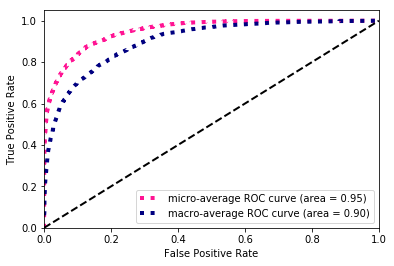

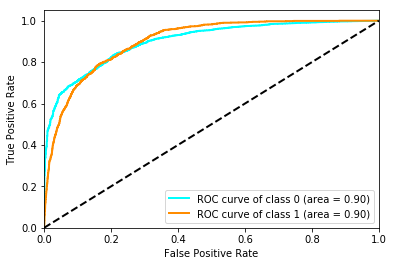

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.925436     0.588962     0.873770     0.757199      0.881128
precision     0.949978     0.515541     0.873770     0.732759      0.892771
recall        0.902129     0.686769     0.873770     0.794449      0.873770
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.901119     0.901118     0.951057     0.901291           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(41184, 314)
(41184, 2)
(8437, 314)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_305 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_306 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_99 (Batc (None, 256)               1024      
_________________________________________________________________
activation_99 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 256)         

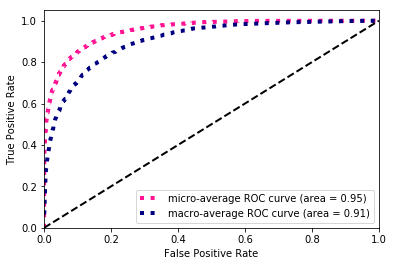

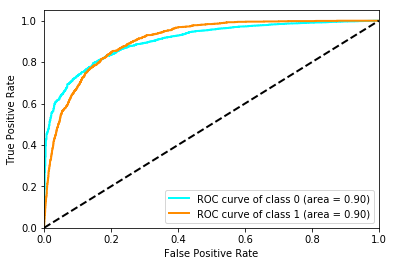

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.926829     0.583994     0.875548     0.755411      0.881684
precision     0.946754     0.521585     0.875548     0.734170      0.890767
recall        0.907726     0.663366     0.875548     0.785546      0.875548
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.904976     0.904976     0.952908     0.905140           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(41184, 314)
(41184, 2)
(8437, 314)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_309 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_310 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_101 (Bat (None, 256)               1024      
_________________________________________________________________
activation_101 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 256)         

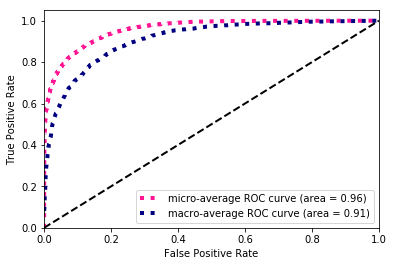

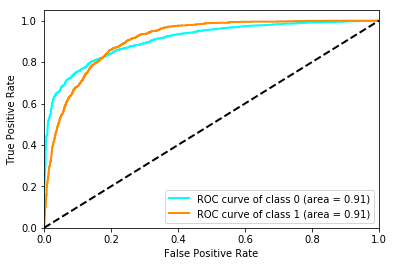

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.928477     0.591650     0.878274     0.760064      0.884123
precision     0.947817     0.529915     0.878274     0.738866      0.892787
recall        0.909910     0.669667     0.878274     0.789788      0.878274
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.909504     0.909504     0.957846     0.909668           NaN

******************** RNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(41184, 314)
(41184, 2)
(8437, 314)
(8437, 2)
(41184, 8, 25)
(41184, 14)
(41184, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_73 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

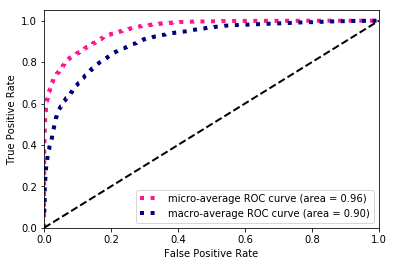

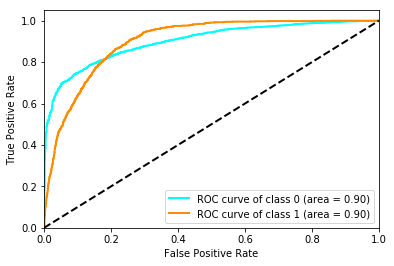

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.925468     0.549854     0.872111     0.737661      0.876006
precision     0.936792     0.512442     0.872111     0.724617      0.880913
recall        0.914414     0.593159     0.872111     0.753787      0.872111
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.901249     0.901249     0.957282     0.901413           NaN

******************** RNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(41184, 314)
(41184, 2)
(8437, 314)
(8437, 2)
(41184, 8, 25)
(41184, 14)
(41184, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_75 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

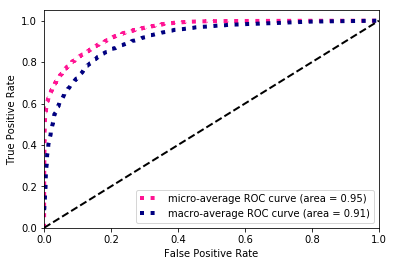

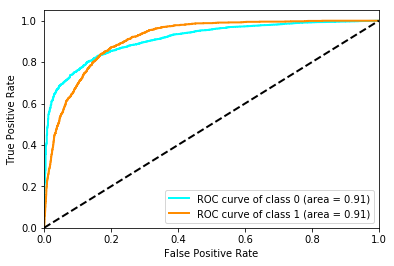

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.916667     0.587156     0.861325     0.751911      0.873276
precision     0.958445     0.482879     0.861325     0.720662      0.895822
recall        0.878378     0.748875     0.861325     0.813627      0.861325
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.912480     0.912480     0.950629     0.912645           NaN

******************** RNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(41184, 314)
(41184, 2)
(8437, 314)
(8437, 2)
(41184, 8, 25)
(41184, 14)
(41184, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_77 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

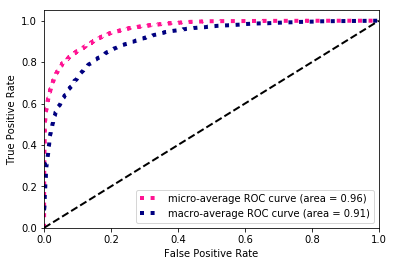

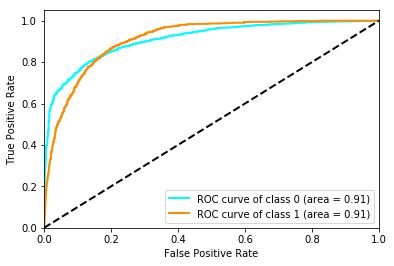

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.926870     0.590536     0.875904     0.758703      0.882581
precision     0.949077     0.522130     0.875904     0.735604      0.892856
recall        0.905678     0.679568     0.875904     0.792623      0.875904
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.911001     0.911001     0.958153     0.911163           NaN

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(41184, 315)
(41184, 2)
(8437, 315)
(8437, 2)
(41184, 8, 25)
(41184, 14)
(41184, 100)
(41184,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

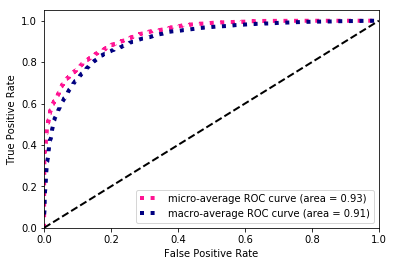

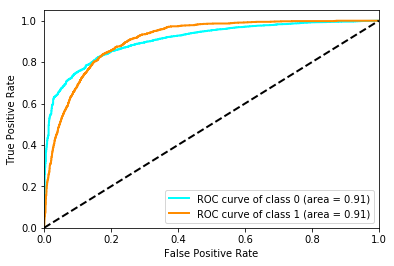

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.903249     0.572987     0.842243     0.738118      0.859760
precision     0.966102     0.445165     0.842243     0.705633      0.897504
recall        0.848075     0.803780     0.842243     0.825928      0.842243
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.908017     0.908017     0.931861     0.908195           NaN

******************** RNN_embed ********************
**********  round  1
load and test: shapes for train and test, X/Y
(41184, 315)
(41184, 2)
(8437, 315)
(8437, 2)
(41184, 8, 25)
(41184, 14)
(41184, 100)
(41184,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

Epoch 33/60
 - 4s - loss: 0.2290 - f1_score: 0.5101 - val_loss: 0.1789 - val_f1_score: 0.2534
Epoch 34/60
 - 4s - loss: 0.2284 - f1_score: 0.5239 - val_loss: 0.1902 - val_f1_score: 0.2263
Epoch 35/60
 - 4s - loss: 0.2280 - f1_score: 0.5198 - val_loss: 0.1442 - val_f1_score: 0.0749


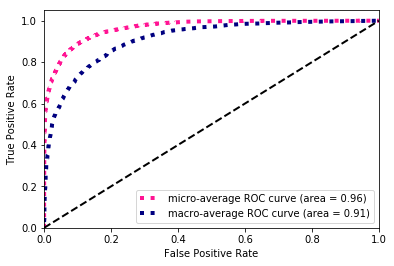

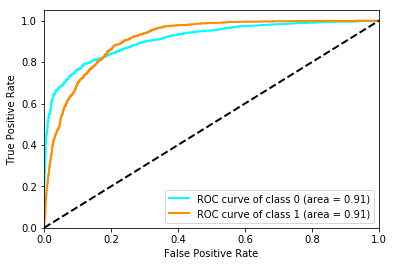

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.939176     0.574408     0.893564     0.756792      0.891143
precision     0.932105     0.606607     0.893564     0.769356      0.889243
recall        0.946355     0.545455     0.893564     0.745905      0.893564
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.910605     0.910610     0.964507     0.910769           NaN

******************** RNN_embed ********************
**********  round  2
load and test: shapes for train and test, X/Y
(41184, 315)
(41184, 2)
(8437, 315)
(8437, 2)
(41184, 8, 25)
(41184, 14)
(41184, 100)
(41184,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

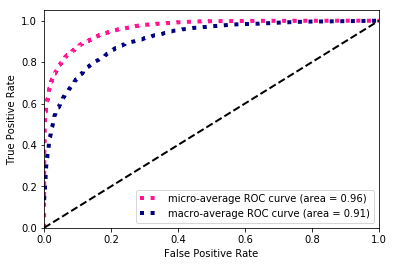

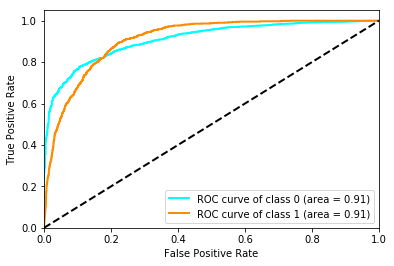

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.934869     0.584790     0.887401     0.759830      0.888770
precision     0.939118     0.568394     0.887401     0.753756      0.890301
recall        0.930658     0.602160     0.887401     0.766409      0.887401
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.910275     0.910275     0.962513     0.910432           NaN

******************** ATT ********************
**********  round  0
load and test: shapes for train and test, X/Y
(41184, 315)
(41184, 2)
(8437, 315)
(8437, 2)
(41184, 8, 25)
(41184, 14)
(41184, 100)
(41184,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_85 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
lstm_86 (LSTM)                  (None, 8, 128)       131584      lstm_85[0][0]                    
__________________________________________________________________________________________________


Epoch 27/60
 - 4s - loss: 0.2299 - f1_score: 0.5135 - val_loss: 0.1539 - val_f1_score: 0.1679
Epoch 28/60
 - 4s - loss: 0.2290 - f1_score: 0.5113 - val_loss: 0.1469 - val_f1_score: 0.0339


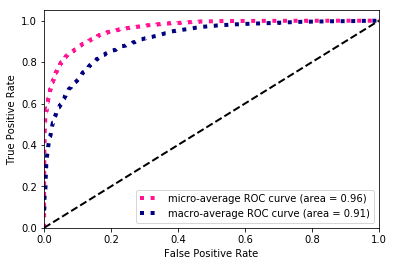

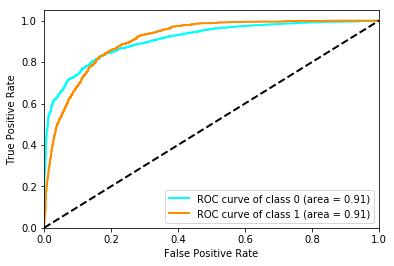

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.933984     0.588336     0.886215     0.761160      0.888469
precision     0.941103     0.561835     0.886215     0.751469      0.891160
recall        0.926972     0.617462     0.886215     0.772217      0.886215
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.909396     0.909396     0.960927     0.909558           NaN

******************** ATT ********************
**********  round  1
load and test: shapes for train and test, X/Y
(41184, 315)
(41184, 2)
(8437, 315)
(8437, 2)
(41184, 8, 25)
(41184, 14)
(41184, 100)
(41184,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_87 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
lstm_88 (LSTM)                  (None, 8, 128)       131584      lstm_87[0][0]                    
__________________________________________________________________________________________________


Epoch 27/60
 - 4s - loss: 0.2331 - f1_score: 0.5090 - val_loss: 0.1604 - val_f1_score: 0.0282
Epoch 28/60
 - 4s - loss: 0.2327 - f1_score: 0.5180 - val_loss: 0.1523 - val_f1_score: 0.0000e+00
Epoch 29/60
 - 4s - loss: 0.2321 - f1_score: 0.5134 - val_loss: 0.1481 - val_f1_score: 0.0500
Epoch 30/60
 - 4s - loss: 0.2307 - f1_score: 0.5129 - val_loss: 0.1749 - val_f1_score: 0.1690
Epoch 31/60
 - 4s - loss: 0.2309 - f1_score: 0.5167 - val_loss: 0.1519 - val_f1_score: 0.0000e+00
Epoch 32/60
 - 4s - loss: 0.2323 - f1_score: 0.5097 - val_loss: 0.1644 - val_f1_score: 0.2363
Epoch 33/60
 - 4s - loss: 0.2315 - f1_score: 0.5167 - val_loss: 0.1854 - val_f1_score: 0.1450
Epoch 34/60
 - 4s - loss: 0.2312 - f1_score: 0.5142 - val_loss: 0.1451 - val_f1_score: 0.0000e+00
Epoch 35/60
 - 4s - loss: 0.2303 - f1_score: 0.5172 - val_loss: 0.1496 - val_f1_score: 0.1381
Epoch 36/60
 - 4s - loss: 0.2303 - f1_score: 0.5133 - val_loss: 0.1458 - val_f1_score: 0.0000e+00
Epoch 37/60
 - 4s - loss: 0.2306 - f1_score:

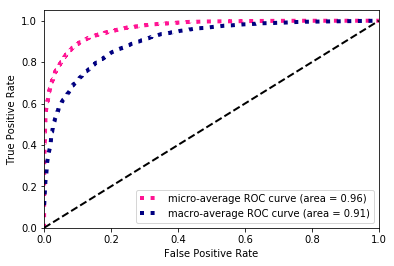

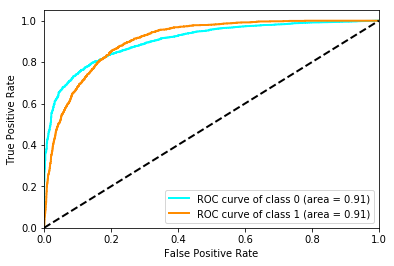

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.939808     0.573755     0.894512     0.756781      0.891605
precision     0.931367     0.613101     0.894512     0.772234      0.889457
recall        0.948403     0.539154     0.894512     0.743778      0.894512
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.905479     0.905479     0.963025     0.905638           NaN

******************** ATT ********************
**********  round  2
load and test: shapes for train and test, X/Y
(41184, 315)
(41184, 2)
(8437, 315)
(8437, 2)
(41184, 8, 25)
(41184, 14)
(41184, 100)
(41184,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_89 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
lstm_90 (LSTM)                  (None, 8, 128)       131584      lstm_89[0][0]                    
__________________________________________________________________________________________________


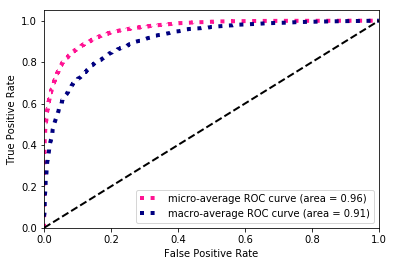

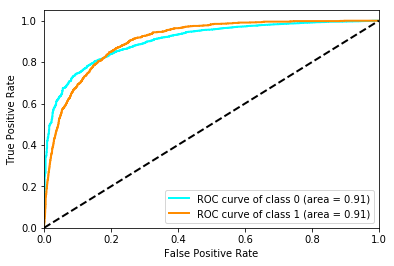

0            1    micro avg    macro avg  weighted avg
index                                                                      
f1-score      0.932080     0.590587     0.883489     0.761334      0.887112
precision     0.943753     0.549612     0.883489     0.746683      0.891851
recall        0.920693     0.638164     0.883489     0.779429      0.883489
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.905697     0.905697     0.957528     0.905859           NaN

In [20]:
Houston =compare_models('Houston',w=[1,1])

In [21]:
Houston.to_csv('Houston.csv')
Houston

DNN       RNN  RNN_embed       ATT
0_f1-score              0.926914  0.923002   0.925765  0.935291
1_f1-score              0.588202  0.575849   0.577395  0.584226
weighted avg_f1-score   0.882312  0.877288   0.879891  0.889062
0_precision             0.948183  0.948105   0.945775  0.938741
1_precision             0.522347  0.505817   0.540055  0.574849
weighted avg_precision  0.892108  0.889864   0.892349  0.890823
0_recall                0.906588  0.899490   0.908363  0.932023
1_recall                0.673267  0.673867   0.650465  0.598260
weighted avg_recall     0.875864  0.869780   0.874402  0.888072
0_auc                   0.905200  0.908243   0.909632  0.906858
1_auc                   0.905200  0.908243   0.909634  0.906857

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(21102, 314)
(21102, 2)
(4385, 314)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_376 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_377 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_121 (Bat (None, 256)               1024      
_________________________________________________________________
activation_121 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 256)         

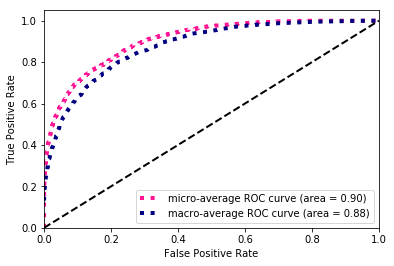

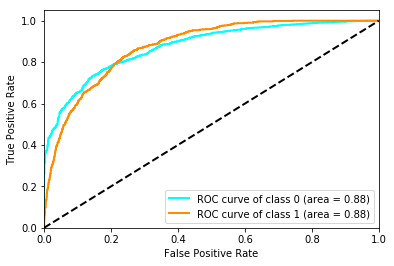

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.871359    0.610652     0.806613     0.741006      0.815532
precision     0.912905    0.536723     0.806613     0.724814      0.832350
recall        0.833430    0.708200     0.806613     0.770815      0.806613
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.875898    0.875898     0.904388     0.876158           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(21102, 314)
(21102, 2)
(4385, 314)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_380 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_381 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_123 (Bat (None, 256)               1024      
_________________________________________________________________
activation_123 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 256)         

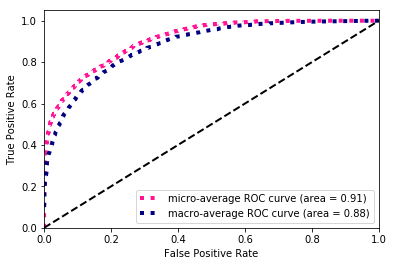

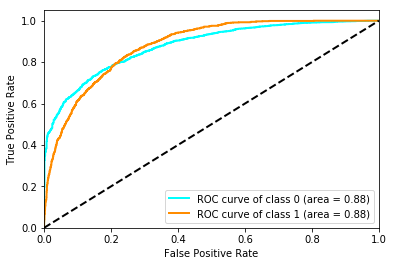

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.868578    0.618942     0.804561     0.743760      0.815121
precision     0.920976    0.531298     0.804561     0.726137      0.837530
recall        0.821822    0.741214     0.804561     0.781518      0.804561
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.879667    0.879667     0.907710     0.879914           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(21102, 314)
(21102, 2)
(4385, 314)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_384 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_385 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_125 (Bat (None, 256)               1024      
_________________________________________________________________
activation_125 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 256)         

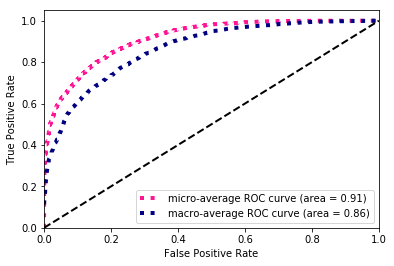

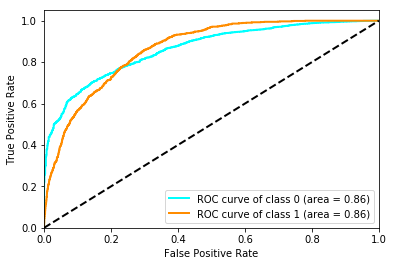

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.884447    0.586639     0.819384     0.735543      0.820675
precision     0.889378    0.575230     0.819384     0.732304      0.822107
recall        0.879571    0.598509     0.819384     0.739040      0.819384
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.863851    0.863851     0.913855     0.864120           NaN

******************** RNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(21102, 314)
(21102, 2)
(4385, 314)
(4385, 2)
(21102, 8, 25)
(21102, 14)
(21102, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_91 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

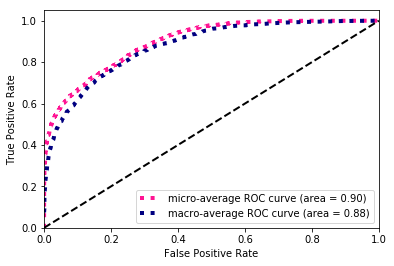

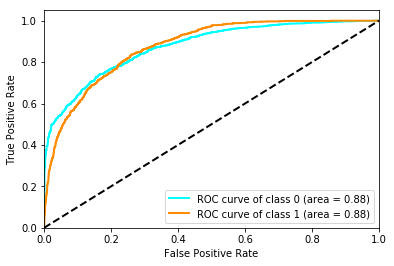

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.854829    0.603404     0.787457     0.729116      0.800989
precision     0.922663    0.502481     0.787457     0.712572      0.832686
recall        0.796286    0.755059     0.787457     0.775672      0.787457
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.875033    0.875033     0.896823     0.875284           NaN

******************** RNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(21102, 314)
(21102, 2)
(4385, 314)
(4385, 2)
(21102, 8, 25)
(21102, 14)
(21102, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_93 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

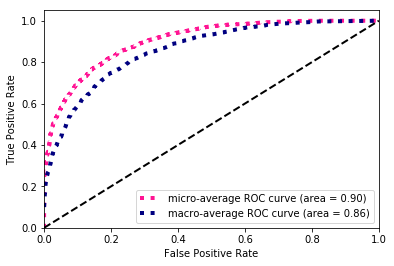

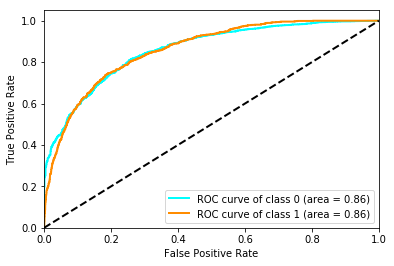

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.876279    0.613358     0.812543     0.744819      0.819978
precision     0.910256    0.549284     0.812543     0.729770      0.832958
recall        0.844748    0.694356     0.812543     0.769552      0.812543
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.858741    0.858740     0.902645     0.859006           NaN

******************** RNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(21102, 314)
(21102, 2)
(4385, 314)
(4385, 2)
(21102, 8, 25)
(21102, 14)
(21102, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_95 (LSTM)                  (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

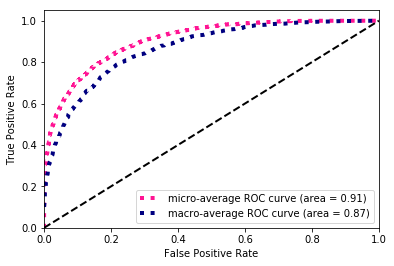

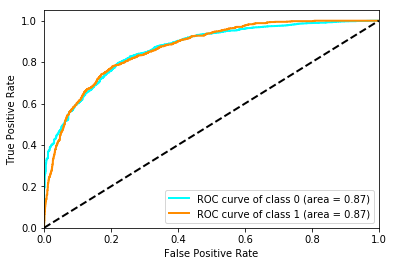

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.877468    0.619204     0.814595     0.748336      0.822164
precision     0.912825    0.552676     0.814595     0.732750      0.835703
recall        0.844748    0.703940     0.814595     0.774344      0.814595
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.866029    0.866029     0.906195     0.866298           NaN

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(21102, 315)
(21102, 2)
(4385, 315)
(4385, 2)
(21102, 8, 25)
(21102, 14)
(21102, 100)
(21102,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_31 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

Epoch 33/60
 - 2s - loss: 0.3270 - f1_score: 0.6342 - val_loss: 0.2908 - val_f1_score: 0.1917
Epoch 34/60
 - 2s - loss: 0.3262 - f1_score: 0.6327 - val_loss: 0.3203 - val_f1_score: 0.3756
Epoch 35/60
 - 2s - loss: 0.3279 - f1_score: 0.6283 - val_loss: 0.3421 - val_f1_score: 0.4221
Epoch 36/60
 - 2s - loss: 0.3258 - f1_score: 0.6317 - val_loss: 0.3089 - val_f1_score: 0.1796
Epoch 37/60
 - 2s - loss: 0.3247 - f1_score: 0.6386 - val_loss: 0.2947 - val_f1_score: 0.3723
Epoch 38/60
 - 2s - loss: 0.3265 - f1_score: 0.6376 - val_loss: 0.3026 - val_f1_score: 0.3099
Epoch 39/60
 - 2s - loss: 0.3242 - f1_score: 0.6306 - val_loss: 0.3506 - val_f1_score: 0.4266


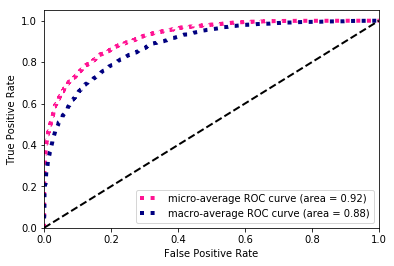

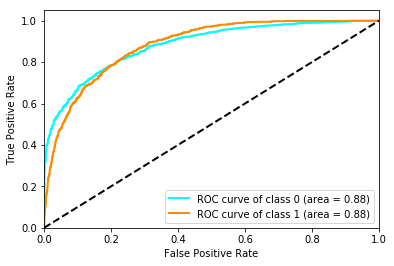

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.893063    0.640119     0.835120     0.766591      0.838898
precision     0.910709    0.600935     0.835120     0.755822      0.844374
recall        0.876088    0.684771     0.835120     0.780430      0.835120
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.882386    0.882386     0.921849     0.882637           NaN

******************** RNN_embed ********************
**********  round  1
load and test: shapes for train and test, X/Y
(21102, 315)
(21102, 2)
(4385, 315)
(4385, 2)
(21102, 8, 25)
(21102, 14)
(21102, 100)
(21102,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

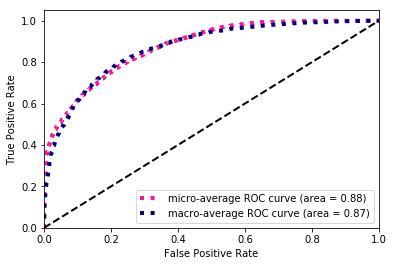

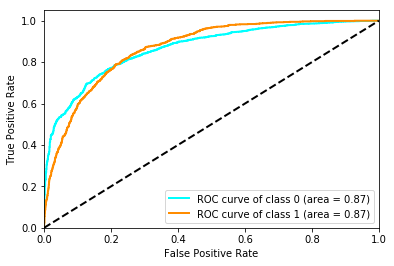

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.845567    0.607431     0.778335     0.726499      0.794573
precision     0.934340    0.489265     0.778335     0.711802      0.839032
recall        0.772200    0.800852     0.778335     0.786526      0.778335
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.867656    0.867656     0.875081     0.867930           NaN

******************** RNN_embed ********************
**********  round  2
load and test: shapes for train and test, X/Y
(21102, 315)
(21102, 2)
(4385, 315)
(4385, 2)
(21102, 8, 25)
(21102, 14)
(21102, 100)
(21102,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

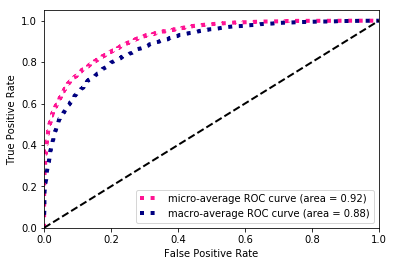

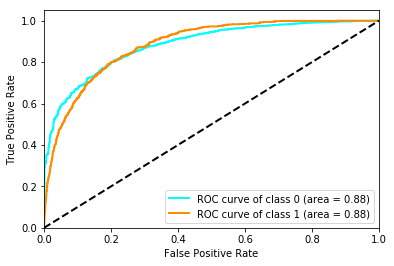

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.885285    0.637915     0.825770     0.761600      0.832314
precision     0.917237    0.574722     0.825770     0.745980      0.843891
recall        0.855485    0.716720     0.825770     0.786102      0.825770
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.884373    0.884373     0.919873     0.884626           NaN

******************** ATT ********************
**********  round  0
load and test: shapes for train and test, X/Y
(21102, 315)
(21102, 2)
(4385, 315)
(4385, 2)
(21102, 8, 25)
(21102, 14)
(21102, 100)
(21102,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_103 (LSTM)                 (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
lstm_104 (LSTM)                 (None, 8, 128)       131584      lstm_103[0][0]                   
__________________________________________________________________________________________________


Epoch 27/60
 - 2s - loss: 0.3319 - f1_score: 0.6288 - val_loss: 0.3434 - val_f1_score: 0.4130
Epoch 28/60
 - 2s - loss: 0.3300 - f1_score: 0.6234 - val_loss: 0.2943 - val_f1_score: 0.3719
Epoch 29/60
 - 2s - loss: 0.3299 - f1_score: 0.6317 - val_loss: 0.3145 - val_f1_score: 0.3715
Epoch 30/60
 - 2s - loss: 0.3296 - f1_score: 0.6313 - val_loss: 0.2932 - val_f1_score: 0.3404
Epoch 31/60
 - 2s - loss: 0.3300 - f1_score: 0.6278 - val_loss: 0.2827 - val_f1_score: 0.2139
Epoch 32/60
 - 2s - loss: 0.3294 - f1_score: 0.6326 - val_loss: 0.3634 - val_f1_score: 0.4547
Epoch 33/60
 - 2s - loss: 0.3286 - f1_score: 0.6344 - val_loss: 0.2915 - val_f1_score: 0.2152
Epoch 34/60
 - 2s - loss: 0.3281 - f1_score: 0.6289 - val_loss: 0.2948 - val_f1_score: 0.3803
Epoch 35/60
 - 2s - loss: 0.3273 - f1_score: 0.6308 - val_loss: 0.2982 - val_f1_score: 0.3745
Epoch 36/60
 - 2s - loss: 0.3282 - f1_score: 0.6314 - val_loss: 0.2951 - val_f1_score: 0.3925
Epoch 37/60
 - 2s - loss: 0.3276 - f1_score: 0.6277 - val_lo

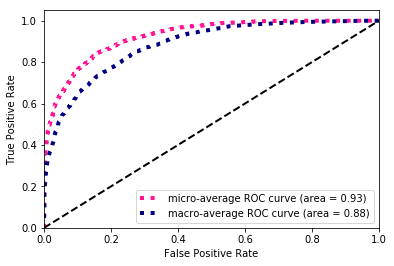

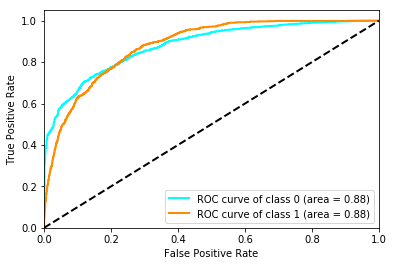

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.900101    0.627091     0.842417     0.763596      0.841639
precision     0.896860    0.635667     0.842417     0.766264      0.840928
recall        0.903366    0.618743     0.842417     0.761055      0.842417
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.880426    0.880426     0.925221     0.880678           NaN

******************** ATT ********************
**********  round  1
load and test: shapes for train and test, X/Y
(21102, 315)
(21102, 2)
(4385, 315)
(4385, 2)
(21102, 8, 25)
(21102, 14)
(21102, 100)
(21102,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_105 (LSTM)                 (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
lstm_106 (LSTM)                 (None, 8, 128)       131584      lstm_105[0][0]                   
__________________________________________________________________________________________________


Epoch 27/60
 - 2s - loss: 0.3297 - f1_score: 0.6266 - val_loss: 0.3290 - val_f1_score: 0.3923
Epoch 28/60
 - 2s - loss: 0.3318 - f1_score: 0.6240 - val_loss: 0.2899 - val_f1_score: 0.0789
Epoch 29/60
 - 2s - loss: 0.3283 - f1_score: 0.6322 - val_loss: 0.3127 - val_f1_score: 0.4266
Epoch 30/60
 - 2s - loss: 0.3290 - f1_score: 0.6268 - val_loss: 0.2906 - val_f1_score: 0.3784


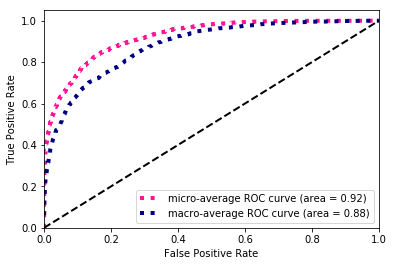

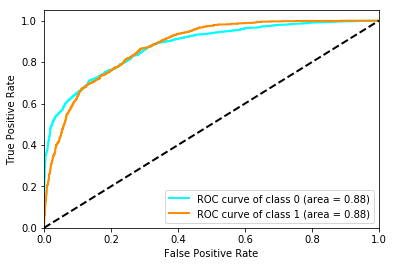

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.895272    0.641090     0.837856     0.768181      0.840842
precision     0.909064    0.609405     0.837856     0.759234      0.844895
recall        0.881892    0.676251     0.837856     0.779072      0.837856
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.878515    0.878516     0.921368     0.878782           NaN

******************** ATT ********************
**********  round  2
load and test: shapes for train and test, X/Y
(21102, 315)
(21102, 2)
(4385, 315)
(4385, 2)
(21102, 8, 25)
(21102, 14)
(21102, 100)
(21102,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_107 (LSTM)                 (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
lstm_108 (LSTM)                 (None, 8, 128)       131584      lstm_107[0][0]                   
__________________________________________________________________________________________________


Epoch 27/60
 - 2s - loss: 0.3304 - f1_score: 0.6274 - val_loss: 0.2893 - val_f1_score: 0.3612
Epoch 28/60
 - 2s - loss: 0.3302 - f1_score: 0.6238 - val_loss: 0.2985 - val_f1_score: 0.3648
Epoch 29/60
 - 2s - loss: 0.3296 - f1_score: 0.6282 - val_loss: 0.3973 - val_f1_score: 0.4341
Epoch 30/60
 - 2s - loss: 0.3278 - f1_score: 0.6277 - val_loss: 0.2868 - val_f1_score: 0.0942
Epoch 31/60
 - 2s - loss: 0.3283 - f1_score: 0.6270 - val_loss: 0.3353 - val_f1_score: 0.4320
Epoch 32/60
 - 2s - loss: 0.3303 - f1_score: 0.6256 - val_loss: 0.3057 - val_f1_score: 0.4371


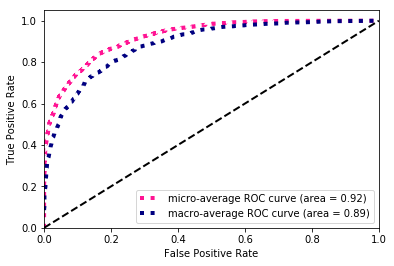

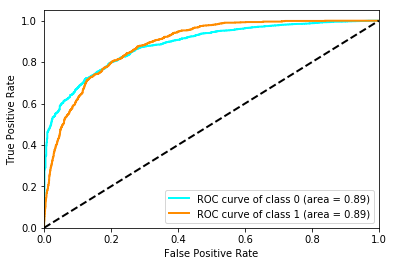

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.895103    0.647439     0.838312     0.771271      0.842068
precision     0.913070    0.607276     0.838312     0.760173      0.847587
recall        0.877829    0.693291     0.838312     0.785560      0.838312
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.885799    0.885799     0.922856     0.886046           NaN

In [22]:
Charlotte = compare_models('Charlotte',w=[1,1])

In [23]:
Charlotte.to_csv('Charlotte.csv')
Charlotte

DNN       RNN  RNN_embed       ATT
0_f1-score              0.874795  0.869525   0.874639  0.896825
1_f1-score              0.605411  0.611989   0.628488  0.638540
weighted avg_f1-score   0.817109  0.814377   0.821928  0.841516
0_precision             0.907753  0.915248   0.920762  0.906331
1_precision             0.547750  0.534813   0.554974  0.617450
weighted avg_precision  0.830662  0.833782   0.842432  0.844470
0_recall                0.844941  0.828594   0.834591  0.887696
1_recall                0.682641  0.717785   0.734114  0.662762
weighted avg_recall     0.810186  0.804865   0.813075  0.839529
0_auc                   0.873139  0.866601   0.878138  0.881580
1_auc                   0.873139  0.866601   0.878138  0.881580

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(26555, 314)
(26555, 2)
(5345, 314)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_451 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_452 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_145 (Bat (None, 256)               1024      
_________________________________________________________________
activation_145 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 256)         

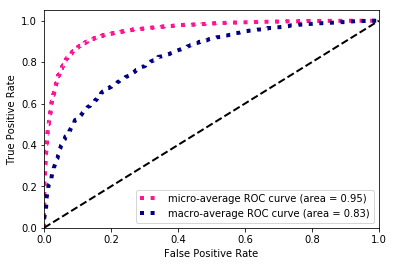

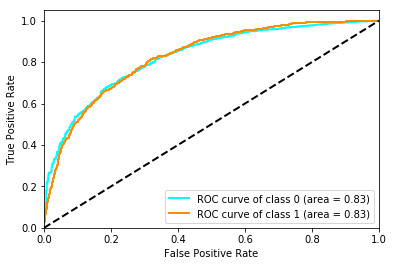

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.936276    0.377016     0.884378     0.656646      0.871194
precision     0.912563    0.505405     0.884378     0.708984      0.865182
recall        0.961253    0.300643     0.884378     0.630948      0.884378
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.826487    0.826488     0.949702     0.826844           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(26555, 314)
(26555, 2)
(5345, 314)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_455 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_456 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_147 (Bat (None, 256)               1024      
_________________________________________________________________
activation_147 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_74 (Dropout)         (None, 256)         

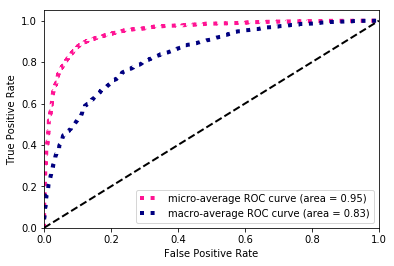

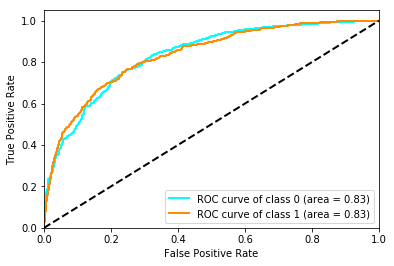

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.937972    0.483421     0.889242     0.710696      0.885075
precision     0.928438    0.528626     0.889242     0.728532      0.881912
recall        0.947703    0.445338     0.889242     0.696520      0.889242
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.834442    0.834442     0.949602     0.834806           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(26555, 314)
(26555, 2)
(5345, 314)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 314)               0         
_________________________________________________________________
dense_459 (Dense)            (None, 512)               161280    
_________________________________________________________________
dense_460 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_149 (Bat (None, 256)               1024      
_________________________________________________________________
activation_149 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_75 (Dropout)         (None, 256)         

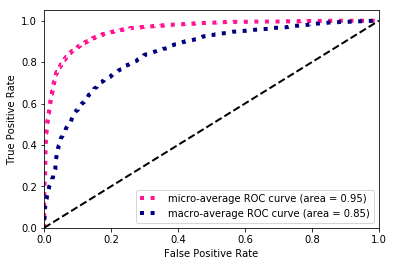

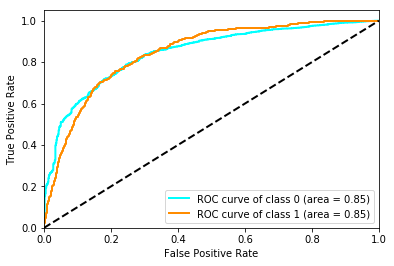

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.938466    0.232030     0.886062     0.585248      0.856258
precision     0.897565    0.538012     0.886062     0.717788      0.855723
recall        0.983273    0.147910     0.886062     0.565592      0.886062
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.845819    0.845819     0.954865     0.846149           NaN

******************** RNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(26555, 314)
(26555, 2)
(5345, 314)
(5345, 2)
(26555, 8, 25)
(26555, 14)
(26555, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_109 (LSTM)                 (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

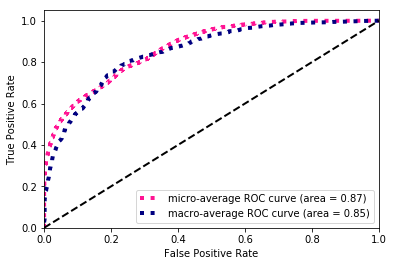

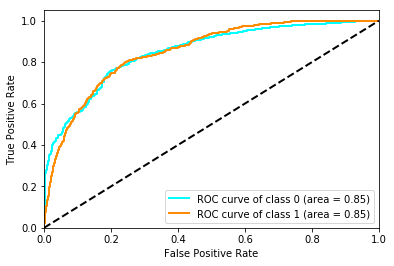

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.850948    0.440889     0.764640     0.645918      0.803229
precision     0.966102    0.304668     0.764640     0.635385      0.889130
recall        0.760322    0.797428     0.764640     0.778875      0.764640
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.850014    0.850014     0.867709     0.850342           NaN

******************** RNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(26555, 314)
(26555, 2)
(5345, 314)
(5345, 2)
(26555, 8, 25)
(26555, 14)
(26555, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_111 (LSTM)                 (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

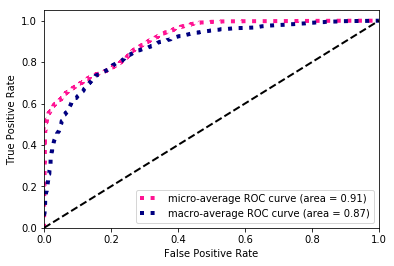

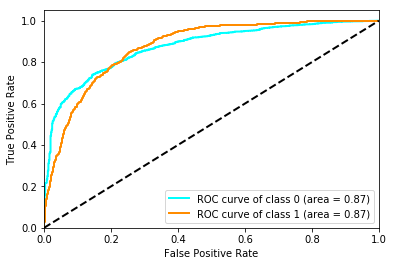

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.865427    0.461394     0.784659     0.663411      0.818410
precision     0.966319    0.325413     0.784659     0.645866      0.891736
recall        0.783612    0.792605     0.784659     0.788108      0.784659
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.874389    0.874389     0.908007     0.874691           NaN

******************** RNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(26555, 314)
(26555, 2)
(5345, 314)
(5345, 2)
(26555, 8, 25)
(26555, 14)
(26555, 100)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_113 (LSTM)                 (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
geohash_input (InputLayer)      (None, 14)           0                                            
__________________________________________________________________________________________________
nlp_input

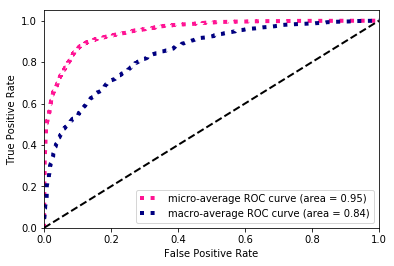

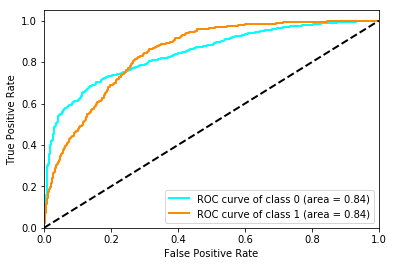

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.935924    0.388560     0.884004     0.662242      0.872227
precision     0.914193    0.502551     0.884004     0.708372      0.866290
recall        0.958713    0.316720     0.884004     0.637716      0.884004
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.844123    0.844123     0.949781     0.844464           NaN

******************** RNN_embed ********************
**********  round  0
load and test: shapes for train and test, X/Y
(26555, 315)
(26555, 2)
(5345, 315)
(5345, 2)
(26555, 8, 25)
(26555, 14)
(26555, 100)
(26555,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_37 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

Epoch 32/60
 - 2s - loss: 0.2625 - f1_score: 0.3442 - val_loss: 0.0892 - val_f1_score: 0.0000e+00
Epoch 33/60
 - 2s - loss: 0.2644 - f1_score: 0.3420 - val_loss: 0.1148 - val_f1_score: 0.0000e+00
Epoch 34/60
 - 2s - loss: 0.2630 - f1_score: 0.3315 - val_loss: 0.1520 - val_f1_score: 0.0000e+00
Epoch 35/60
 - 2s - loss: 0.2635 - f1_score: 0.3557 - val_loss: 0.0818 - val_f1_score: 0.0000e+00
Epoch 36/60
 - 2s - loss: 0.2638 - f1_score: 0.3381 - val_loss: 0.0701 - val_f1_score: 0.0000e+00
Epoch 37/60
 - 2s - loss: 0.2637 - f1_score: 0.3471 - val_loss: 0.0843 - val_f1_score: 0.0000e+00
Epoch 38/60
 - 2s - loss: 0.2623 - f1_score: 0.3392 - val_loss: 0.1632 - val_f1_score: 0.0672
Epoch 39/60
 - 2s - loss: 0.2612 - f1_score: 0.3598 - val_loss: 0.0868 - val_f1_score: 0.0000e+00


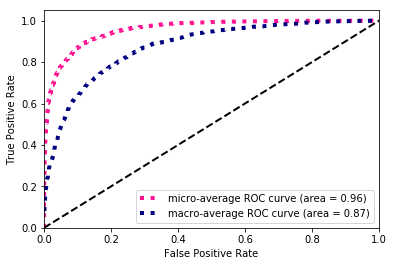

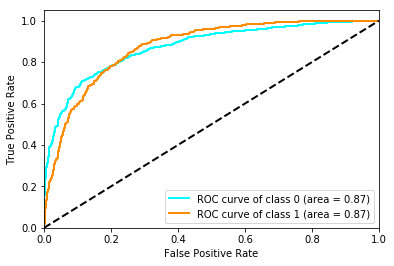

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.936211    0.490756     0.886623     0.713483      0.884373
precision     0.930919    0.514085     0.886623     0.722502      0.882412
recall        0.941563    0.469453     0.886623     0.705508      0.886623
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.873628    0.873628     0.956731     0.873941           NaN

******************** RNN_embed ********************
**********  round  1
load and test: shapes for train and test, X/Y
(26555, 315)
(26555, 2)
(5345, 315)
(5345, 2)
(26555, 8, 25)
(26555, 14)
(26555, 100)
(26555,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

Epoch 33/60
 - 2s - loss: 0.2633 - f1_score: 0.3655 - val_loss: 0.1175 - val_f1_score: 0.0000e+00


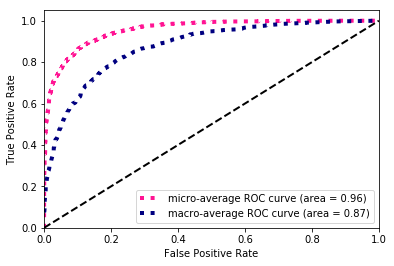

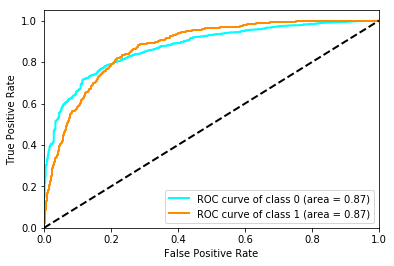

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.932952    0.493195     0.881572     0.713073      0.881777
precision     0.933446    0.491228     0.881572     0.712337      0.881985
recall        0.932458    0.495177     0.881572     0.713818      0.881572
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.873880    0.873880     0.955267     0.874181           NaN

******************** RNN_embed ********************
**********  round  2
load and test: shapes for train and test, X/Y
(26555, 315)
(26555, 2)
(5345, 315)
(5345, 2)
(26555, 8, 25)
(26555, 14)
(26555, 100)
(26555,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
embedding_39 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
_____________________________________________________________________________________________

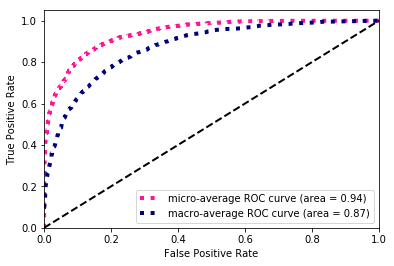

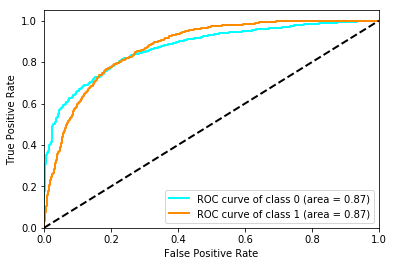

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.916721    0.505195     0.857437     0.710958      0.868832
precision     0.947368    0.423747     0.857437     0.685558      0.886434
recall        0.887995    0.625402     0.857437     0.756698      0.857437
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.872309    0.872309     0.938621     0.872612           NaN

******************** ATT ********************
**********  round  0
load and test: shapes for train and test, X/Y
(26555, 315)
(26555, 2)
(5345, 315)
(5345, 2)
(26555, 8, 25)
(26555, 14)
(26555, 100)
(26555,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_121 (LSTM)                 (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
lstm_122 (LSTM)                 (None, 8, 128)       131584      lstm_121[0][0]                   
__________________________________________________________________________________________________


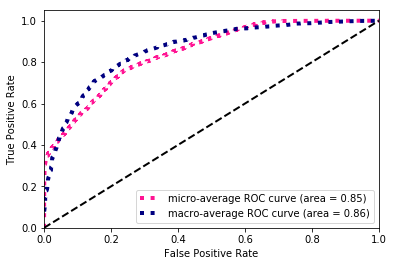

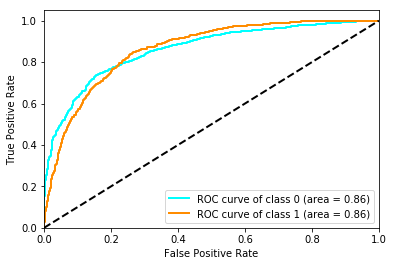

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.847264    0.443769     0.760337     0.645516      0.800309
precision     0.969705    0.303986     0.760337     0.636845      0.892235
recall        0.752276    0.821543     0.760337     0.786910      0.760337
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.861589    0.861589     0.845441     0.861890           NaN

******************** ATT ********************
**********  round  1
load and test: shapes for train and test, X/Y
(26555, 315)
(26555, 2)
(5345, 315)
(5345, 2)
(26555, 8, 25)
(26555, 14)
(26555, 100)
(26555,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_123 (LSTM)                 (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
lstm_124 (LSTM)                 (None, 8, 128)       131584      lstm_123[0][0]                   
__________________________________________________________________________________________________


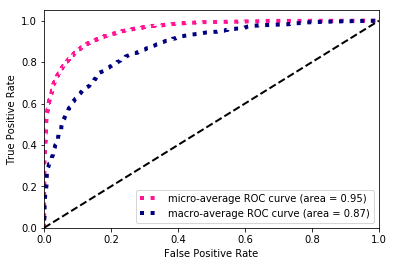

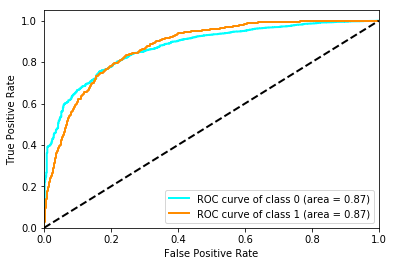

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.931828    0.508449     0.880262     0.720138      0.882559
precision     0.937621    0.486765     0.880262     0.712193      0.885154
recall        0.926106    0.532154     0.880262     0.729130      0.880262
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.873136    0.873137     0.954106     0.873430           NaN

******************** ATT ********************
**********  round  2
load and test: shapes for train and test, X/Y
(26555, 315)
(26555, 2)
(5345, 315)
(5345, 2)
(26555, 8, 25)
(26555, 14)
(26555, 100)
(26555,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 8, 25)        0                                            
__________________________________________________________________________________________________
lstm_125 (LSTM)                 (None, 8, 128)       78848       main_input[0][0]                 
__________________________________________________________________________________________________
lstm_126 (LSTM)                 (None, 8, 128)       131584      lstm_125[0][0]                   
__________________________________________________________________________________________________


Epoch 26/60
 - 2s - loss: 0.2636 - f1_score: 0.3550 - val_loss: 0.0816 - val_f1_score: 0.0000e+00
Epoch 27/60
 - 2s - loss: 0.2657 - f1_score: 0.3549 - val_loss: 0.1106 - val_f1_score: 0.0260
Epoch 28/60
 - 2s - loss: 0.2640 - f1_score: 0.3654 - val_loss: 0.1240 - val_f1_score: 0.0247
Epoch 29/60
 - 2s - loss: 0.2633 - f1_score: 0.3529 - val_loss: 0.1014 - val_f1_score: 0.0222
Epoch 30/60
 - 3s - loss: 0.2635 - f1_score: 0.3498 - val_loss: 0.1001 - val_f1_score: 0.0000e+00
Epoch 31/60
 - 2s - loss: 0.2631 - f1_score: 0.3672 - val_loss: 0.0995 - val_f1_score: 0.0000e+00
Epoch 32/60
 - 2s - loss: 0.2641 - f1_score: 0.3431 - val_loss: 0.1283 - val_f1_score: 0.0000e+00
Epoch 33/60
 - 2s - loss: 0.2642 - f1_score: 0.3315 - val_loss: 0.0962 - val_f1_score: 0.0000e+00
Epoch 34/60
 - 2s - loss: 0.2621 - f1_score: 0.3602 - val_loss: 0.0843 - val_f1_score: 0.0000e+00
Epoch 35/60
 - 2s - loss: 0.2619 - f1_score: 0.3511 - val_loss: 0.0958 - val_f1_score: 0.1176
Epoch 36/60
 - 2s - loss: 0.2631 - f

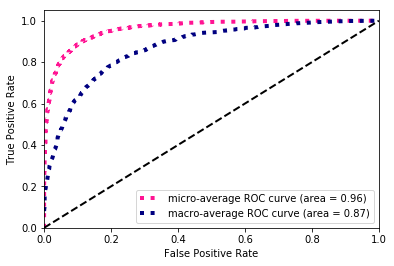

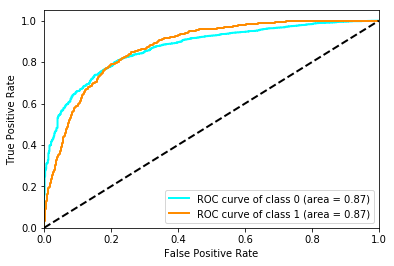

0           1    micro avg    macro avg  weighted avg
index                                                                     
f1-score      0.941583    0.321133     0.892423     0.631358      0.869381
precision     0.905078    0.604444     0.892423     0.754761      0.870093
recall        0.981156    0.218650     0.892423     0.599903      0.892423
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.871153    0.871154     0.960798     0.871468           NaN

In [24]:
Dallas = compare_models('Dallas',w=[1,1])

In [25]:
Dallas.to_csv('Dallas.csv')
Dallas

DNN       RNN  RNN_embed       ATT
0_f1-score              0.937571  0.884100   0.928628  0.906891
1_f1-score              0.364156  0.430281   0.496382  0.424450
weighted avg_f1-score   0.870842  0.831289   0.878327  0.850750
0_precision             0.912855  0.948871   0.937245  0.937468
1_precision             0.524014  0.377544   0.476353  0.465065
weighted avg_precision  0.867606  0.882386   0.883610  0.882494
0_recall                0.964077  0.834216   0.920672  0.886513
1_recall                0.297964  0.635584   0.530011  0.524116
weighted avg_recall     0.886561  0.811101   0.875210  0.844341
0_auc                   0.835582  0.856175   0.873272  0.868626
1_auc                   0.835583  0.856175   0.873273  0.868627